In [1493]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Try to do a simple Integral matching to evaluate yield function.
This is like Damic's integral method:
https://arxiv.org/pdf/1608.00957.pdf

We have to cut some corners and make some additional assumptions though.
One is that the individuals steps of composite NRs from (n,gamma) probably should each have a different yield applied. But this doesn't let us order the events by energy, which is needed for this analysis.
Another is that we have unknown relative normalizations between the simulated ER, NR, and (n,gamma) datasets. Will have to handle that somehow.

The main idea is this:

$\sum^{E_{ee,max}}_{E_{ee,i}} R_{meas,i} = \sum^{E_{ee,max}}_{E_{ee,i}} R_{ER,i} + \sum^{E_{nr,max}}_{E_{nr,j}} (R_{NR,j} + R_{NG,j})$

In [1]:
#Set up notebook and load some R68 constants (V, eps, etc.)
exec(open("nb_setup.py").read())#Is there a better way to do this?
from constants import *

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles


In [2]:
from matplotlib.pyplot import *
from tqdm.notebook import tqdm
import R68_yield as Yield

dict_keys(['xx', 'yy', 'ex', 'ey'])


In [3]:
#Load the data
import R68_load as r68

meas=r68.load_measured(keVmax=10)
#meas=r68.load_measured()
g4=r68.load_G4(load_frac=1)
#cap=r68.load_simcap(file='/data/chocula/villaa/cascadeSimData/si28_R68_400k.pkl', rcapture=0.161, load_frac=0.1)
cap=r68.load_simcap(file='/data/chocula/villaa/cascadeSimData/v3_400k.pkl',
                    rcapture=0.218, load_frac=1)

Loading Measured Data...
PuBe events:  (829944,)
Bkg events:  (222484,)
Loading Geant4 Data...
(528848, 7)
(129555, 7)
Loading NRs...
1.1  min
Loading ERs...
0.3  min
Loading (n,gamma) Data...
382155


In [4]:
#Each returns a dictionary with relevant values
#print(meas)
#print(g4)
#print(cap)

In [5]:
Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,201)

#Emax = 10000 #eVee
#Ebins=np.linspace(0,Emax,1001)

Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

In [6]:
import R68_spec_tools as spec
#uncertainty is (high,low)
R_meas,dR_meas=spec.doBkgSub(meas, Ebins, Efit_min=50,Efit_max=2e3,\
                             doEffsyst=True, doBurstLeaksyst=True,\
                             output='reco-rate')

../python/R68_spec_tools.py:55: RuntimeWarning: divide by zero encountered in true_divide
  (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 +\
../python/R68_spec_tools.py:60: RuntimeWarning: divide by zero encountered in true_divide
  R_meas_Bkg = N_meas_Bkg/TE_Bkg


/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


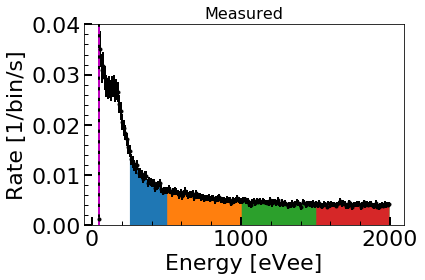

In [7]:
#Illustration of method

# Example ERs, NRs from a later calculation
#255.0 806.3832567888599
#505.0 1967.2490338155576
#1005.0 4045.3075738134753
#1505.0 5739.940139258986
#1995.0 7281.31517699986

Elim_er=[255.0,505.0,1005.0,1505.0,1995.0]
Elim_nr=[806.3832567888599, 1967.2490338155576, 4045.3075738134753, 5739.940139258986, 7281.31517699986]

errorbar(Ebin_ctr,R_meas,dR_meas, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')

for Elim in Elim_er[:-1]:
    cut=(Ebin_ctr>=Elim)&(Ebin_ctr<=Elim_er[-1])
    fill_between(Ebin_ctr[cut],R_meas[cut])

axvline(50,linestyle='--',color='m')
xlabel('Energy [eVee]')
ylabel('Rate [1/bin/s]')
title('Measured',size=16)
ylim(0,0.04)

tight_layout()
savefig('figures/intmeth_meas_eg.png')

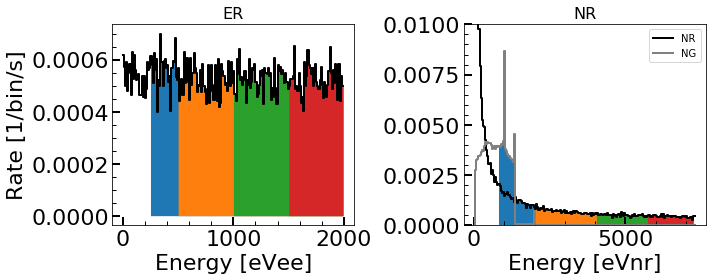

In [1586]:
fig,axs=subplots(1,2,figsize=(10,4))

c,b=np.histogram(np.sum(g4['ER']['E'],axis=1),bins=Ebins)
bctr=(b[:-1]+b[1:])/2
axs[0].step(bctr,c/tlive_er,color='k',where='mid')
axs[0].set_prop_cycle(None)

for Elim in Elim_er[:-1]:
    cut=(bctr>=Elim)&(bctr<=Elim_er[-1])
    axs[0].fill_between(bctr[cut],(c/tlive_er)[cut])

axs[0].set_title('ER',size=16)
axs[0].set_xlabel('Energy [eVee]')
axs[0].set_ylabel('Rate [1/bin/s]')

Ebnr=np.linspace(0,7.3e3,200)
c,b=np.histogram(np.sum(g4['NR']['E'],axis=1),bins=Ebnr)
bctr=(b[:-1]+b[1:])/2
axs[1].step(bctr,c/tlive_nr,color='k',where='mid',label='NR')

axs[1].set_prop_cycle(None)
for Elim in Elim_nr[:-1]:
    cut=(bctr>=Elim)&(bctr<=Elim_nr[-1])
    axs[1].fill_between(bctr[cut],(c/tlive_nr)[cut])

c,b=np.histogram(np.sum(cap['dE'],axis=1),bins=Ebnr)
bctr=(b[:-1]+b[1:])/2
axs[1].step(bctr,c/tlive_ng,color='gray',where='mid',label='NG')

axs[1].set_prop_cycle(None)
for Elim in Elim_nr[:-1]:
    cut=(bctr>=Elim)&(bctr<=Elim_nr[-1])
    axs[1].fill_between(bctr[cut],(c/tlive_ng)[cut])

axs[1].set_title('NR',size=16)
axs[1].set_xlabel('Energy [eVnr]')
axs[1].set_ylim(0,0.01)
axs[1].legend()
#E_nr=np.sum(g4['NR']['E'],axis=1)
#E_ng=np.sum(cap['dE'],axis=1)

tight_layout()

savefig('figures/intmeth_sim_eg.png')

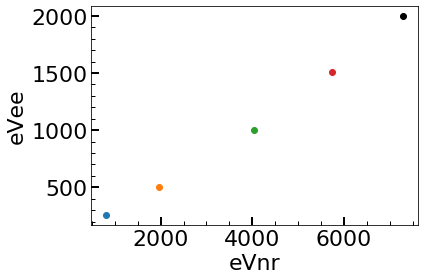

In [9]:
for limnr,limer in zip(Elim_nr[:-1],Elim_er[:-1]):
    plot(limnr,limer,'o')
plot(Elim_nr[-1],Elim_er[-1],'ok')
    
xlabel('eVnr')
ylabel('eVee')
tight_layout()
savefig('figures/intmeth_ernr_eg.png')

In [10]:
from scipy.optimize import fsolve
from scipy.special import erf

def ERtoNR(ER,Y,V,eps):
    if isinstance(Y,(float,int)):
        return ER*(1+V/eps)/(1+Y*V/eps)    
    else:
        func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
        NR_guess = ER
        return fsolve(func, NR_guess)

def NRtoER(NR,Y,V,eps):
    if isinstance(Y,(float,int)):
        return NR*(1+Y*V/eps)/(1+V/eps)
    else:
        return NR*(1+Y.calc(NR)*V/eps)/(1+V/eps)

def Nint(Es,Emin,Emax):
    return np.sum((Es>=Emin)&(Es<Emax))

/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Text(0.5, 1.0, 'NR')

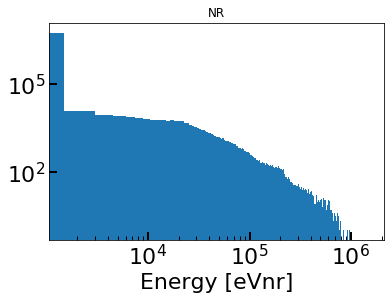

In [59]:
#hist(g4['NR']['E'].flatten(),bins=np.logspace(-3,6,100),log=True);
hist(g4['NR']['E'].flatten(),bins=np.linspace(0,1.5e6,1000),log=True);
#hist(g4['ER']['E'].flatten(),bins=np.logspace(-3,6,100),log=True);

xscale('log')
xlabel('Energy [eVnr]')
title('NR')

In [43]:
#For this analysis, we'll just use the total Edep of each event and apply yield to that.
#How big of an assumption is this?
E_er=np.sum(g4['ER']['E'],axis=1)
E_nr=np.sum(g4['NR']['E'],axis=1)
E_ng=np.sum(cap['dE'],axis=1)

ER: 0.8867211366201705
NR: 0.7972851397121083
NG: 0.9302101586813383


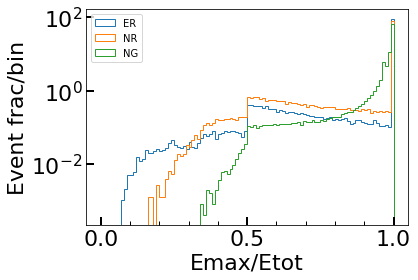

In [44]:
Emax_frac_er=np.max(g4['ER']['E'],axis=1)/np.sum(g4['ER']['E'],axis=1)
Emax_frac_nr=np.max(g4['NR']['E'],axis=1)/np.sum(g4['NR']['E'],axis=1)
Emax_frac_ng=np.max(cap['dE'],axis=1)/np.sum(cap['dE'],axis=1)

#plot(E_er,Emax_frac_er,'.')
#plot(E_nr,Emax_frac_nr,'.')
#xlim(0,10e3)

hist(Emax_frac_er[(E_er>50)&(E_er<30e3)],bins=100,range=(0,1),histtype='step',label='ER',density=True);
hist(Emax_frac_nr[(E_nr>50)&(E_nr<30e3)],bins=100,range=(0,1),histtype='step',label='NR',density=True);
hist(Emax_frac_ng[(E_ng>50)&(E_ng<30e3)],bins=100,range=(0,1),histtype='step',label='NG',density=True);
yscale('log')
ylabel('Event frac/bin')
xlabel('Emax/Etot')

legend(loc='upper left')
print('ER:',np.sum(Emax_frac_er[(E_er>50)&(E_er<30e3)]>0.90)/np.sum((E_er>50)&(E_er<30e3)))
print('NR:',np.sum(Emax_frac_nr[(E_nr>50)&(E_nr<30e3)]>0.90)/np.sum((E_nr>50)&(E_nr<30e3)))
print('NG:',np.sum(Emax_frac_ng[(E_ng>50)&(E_ng<30e3)]>0.90)/np.sum((E_ng>50)&(E_ng<30e3)))

#Ok, most events are dominated by a single scatter
#Don't understand this shelf at 0.5 though... 
#Well, I guess if you have 2 scatters, the smallest max fraction you can have is 0.5...

tight_layout()
savefig('figures/intmeth_EmaxFrac.png')

In [198]:
#Trim events that won't figure into the analysis range
#E_er=E_er[(E_er>0) & (E_er<3e3)]
#E_nr=E_nr[(E_nr>0) & (E_nr<100e3)]

E_er=E_er[(E_er>0) & (E_er<10e3)]
E_nr=E_nr[(E_nr>0) & (E_nr<1000e3)]

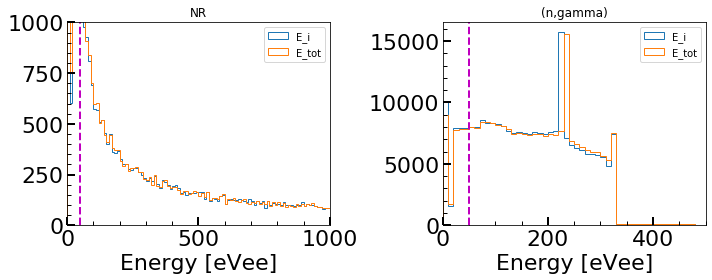

In [1584]:
#How does assuming a single total energy change the eVee spectrum?
fig,axs=subplots(1,2,figsize=(10,4))

#Y=Yield.Yield('Lind',[0.146])
#Y=Yield.Yield('Chav',[0.146,1e3/0.247])
Y=Yield.Yield('Sheco',[0.146,0,1e2])

axs[0].set_title('NR')
axs[0].hist(np.sum(NRtoER(g4['NR']['E'],Y,V,eps),axis=1),bins=Ebins,histtype='step',label='E_i');
axs[0].hist(NRtoER(E_nr,Y,V,eps),bins=Ebins,histtype='step',label='E_tot');
axs[0].axvline(50,linestyle='--',color='m')
axs[0].set_ylim(0,1e3)
axs[0].set_xlim(0,1e3)
axs[0].set_xlabel('Energy [eVee]')
axs[0].legend()


axs[1].set_title('(n,gamma)')
axs[1].hist(np.sum(NRtoER(cap['dE'],Y,V,eps),axis=1),bins=Ebins,histtype='step',label='E_i');
axs[1].hist(NRtoER(E_ng,Y,V,eps),bins=Ebins,histtype='step',label='E_tot');
axs[1].axvline(50,linestyle='--',color='m')
#ylim(0,2e3)
axs[1].set_xlim(0,5e2)
axs[1].set_xlabel('Energy [eVee]')
axs[1].legend()

tight_layout()
#At most, looks like one (n,gamma) peak shifts down a single bin.
#NR seems pretty insensitive to this, which is good because it has the lower fraction of single scatters

tight_layout()
#savefig('figures/intmeth_Etot_effect_eg.png')

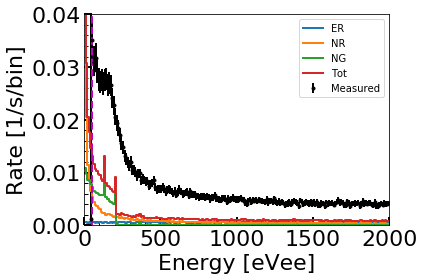

In [385]:
#Spectra with default livetimes and standard yield, Fano

#Y=Yield.Yield('Lind',[0.146])
Y=Yield.Yield('Chav',[0.146,1e3/0.247])


N_er,_=np.histogram(E_er,bins=Ebins)
N_nr,_=np.histogram(NRtoER(E_nr,Y,V,eps),bins=Ebins)
N_ng,_=np.histogram(NRtoER(E_ng,Y,V,eps),bins=Ebins)

R_er=N_er/g4['ER']['tlive']
R_nr=N_nr/g4['NR']['tlive']
R_ng=N_ng/cap['tlive']

#No det res
#R_er = spec.buildAvgSimSpectrum_ee(Ebins, E_er[:,np.newaxis], Yield=1, F=F, scale=1/g4['ER']['tlive'], doDetRes=False, fpeak=1.0, doEffs=False)
#R_nr = spec.buildAvgSimSpectrum_ee(Ebins, E_nr[:,np.newaxis], Yield=Y, F=F, scale=1/g4['NR']['tlive'], doDetRes=False, fpeak=1.0, doEffs=False)
#R_ng = spec.buildAvgSimSpectrum_ee(Ebins, E_ng[:,np.newaxis], Yield=Y, F=F, scale=1/cap['tlive'], doDetRes=False, fpeak=1.0, doEffs=False)

errorbar(Ebin_ctr,R_meas,dR_meas, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')

step(Ebin_ctr,R_er,where='mid',label='ER')
step(Ebin_ctr,R_nr,where='mid',label='NR')
step(Ebin_ctr,R_ng,where='mid',label='NG')


step(Ebin_ctr,R_er+R_nr+R_ng,where='mid',label='Tot')

axvline(50,linestyle='--',color='m')

ylim(0,4e-2)
ylabel('Rate [1/s/bin]')
xlim(0e3,2e3)
xlabel('Energy [eVee]')
#yscale('log')
legend()

tight_layout()
#savefig('figures/intmeth_spectra_compare_default.png')

# First Attempts

In [22]:
#Need to set some NR max I think. 
#Not sure how to choose this because there's NRs up to 1 MeV
#Do we need a fixed (Er,Y) to work from?

Y=Yield.Yield('Lind',[0.146])
E_nr_max=ERtoNR(Ebin_ctr[-1],Y,V,eps)[0]

#Y=Yield.Yield('Chav',[0.146,1e3/0.247])
#E_nr_max=ERtoNR(Ebin_ctr[-1],Y,V,eps)[0]

print(E_nr_max,Ebin_ctr[-1])


fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y,V,eps)[0],E_nr_max)/g4['NR']['tlive'])
fng=0
print(fg4,fng)

E_nrs=[]
E_nr_step=1
E_nr_test=E_nr_max
for i in tqdm(range(len(Ebin_ctr))[::-1]):
    if np.isfinite(R_meas[i]):
        while True:
            R_meas_this=np.sum(R_meas[(Ebin_ctr>Ebin_ctr[i])&(Ebin_ctr<2e3)])
            R_sim_this=fg4*(Nint(E_er,Ebin_ctr[i],2e3)/g4['ER']['tlive'] + Nint(E_nr,E_nr_test,E_nr_max)/g4['NR']['tlive']) + fng*Nint(E_ng,E_nr_test,E_nr_max)/cap['tlive']
            #print(R_meas_this,R_sim_this)

            if (R_meas_this<R_sim_this) or (E_nr_test<0):
                break
            E_nr_test-=E_nr_step
            
        E_nrs.append(E_nr_test)
    else:
        E_nrs.append(np.inf)
E_nrs=np.array(E_nrs[::-1])

6603.998567582085 1995.0
4.6584805707474874 0


/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


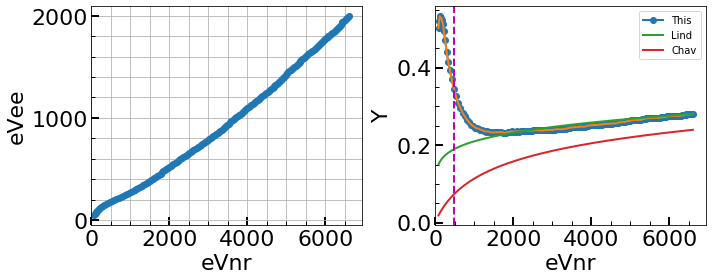

In [31]:
fig,axs=subplots(1,2,figsize=(10,4))

axs[0].plot(E_nrs,Ebin_ctr,'-o')
axs[0].set_xlabel('eVnr')
axs[0].set_xlim(0,None)
axs[0].set_ylabel('eVee')
axs[0].grid(which='both')

#E_ee=E_nr*(1+Y*V/eps)/(1+V/eps)
#=> Y=((E_ee/E_nr)*(1+V/eps)-1)*eps/V
Ys=((Ebin_ctr/E_nrs)*(1+V/eps)-1)*eps/V
axs[1].plot(E_nrs,Ys,'-o',label='This')

from scipy.interpolate import CubicSpline
cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit])
axs[1].plot(E_nrs,Y_fCS(E_nrs))

Y=Yield.Yield('Lind',[0.146])
axs[1].plot(E_nrs,Y.calc(E_nrs),label='Lind')

Y=Yield.Yield('Chav',[0.146,1e3/0.247])
axs[1].plot(E_nrs,Y.calc(E_nrs),label='Chav')
axs[1].axvline(ERtoNR(50,Y,V,eps),linestyle='--',color='m')

axs[1].set_xlabel('eVnr')
axs[1].set_xlim(0,None)
axs[1].set_ylabel('Y')
#axs[1].set_ylim(0,1)
axs[1].legend()

tight_layout()

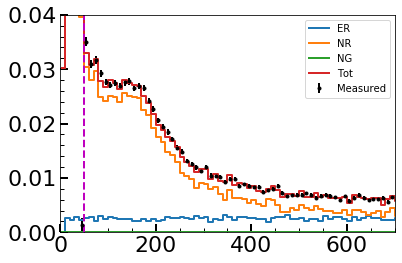

In [32]:
errorbar(Ebin_ctr,R_meas,dR_meas, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')

C_er,_=np.histogram(E_er,bins=Ebins)
R_er=fg4*C_er/g4['ER']['tlive']

Y=Yield.Yield('User',[Y_fCS])
C_nr,_=np.histogram(NRtoER(E_nr,Y,V,eps),bins=Ebins)
R_nr=fg4*C_nr/g4['NR']['tlive']
C_ng,_=np.histogram(NRtoER(E_ng,Y,V,eps),bins=Ebins)
R_ng=fng*C_ng/cap['tlive']


step(Ebin_ctr,R_er,where='mid',label='ER')
step(Ebin_ctr,R_nr,where='mid',label='NR')
step(Ebin_ctr,R_ng,where='mid',label='NG')

step(Ebin_ctr,R_er+R_nr+R_ng,where='mid',label='Tot')

axvline(50,linestyle='--',color='m')

ylim(0,0.04)
xlim(0,7e2)

legend()

Okay, this type of procedure seems to work. We can find an arbitrarily-shaped yield curve that maps the simulated hits to the measured spectra, assuming we fix the simulated normalizations and a single starting yield point.

With fng=0, we get a smooth, but rising yield curve. May be good evidence that we need (n,gamma). Things get a little messy when we include fng>0 because the lines have 0 resolution, so it's a huge increment when we pass over them. Will need to smear them with a procedure like Damic used. They applied $Y_{n-1}$ to sim energies, smeared the eVee spectra, undo with $Y_{n-1}$, then calculate $Y_n$, and repeat.

So we need to package the Yield curve generating portion of the above code into a function and build a smearing function. For this type of analysis, we have to randomly smear each hit to a single new energy, instead of making a gaussian from it like we did in MCMC fit. This is because we need individual events that we can order in both eVee and eVnr to make this work.

In [193]:
#Extract yield curve using the integral method
#Treats each event as a single scatter of the total energy
#fer: ER livetime factor
#fnr: NR livetime factor
#fng: NG livetime factor
#Y_max: Yield value that corresponds to the highest bin edge of Ebins
tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

def extract_Y(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, E_nr_step=1,verbose=True):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global Ebins,R_meas,tlive_er,tlive_nr,tlive_ng, V, eps
    
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    E_er_max=Ebins[-1]
    E_nr_max=ERtoNR(E_er_max,Y_max,V,eps)

    #print(E_nr_max,Ebin_ctr[-1])

    E_nrs=[]
    E_nr_test=E_nr_max
    for i in tqdm(range(len(Ebin_ctr))[::-1],disable= not verbose):
        if np.isfinite(R_meas[i]):
            #Is there a more efficienct way to do this? Yep
            # Am I going to spend time working it out? Nope
            while True:
                R_meas_this=np.sum(R_meas[(Ebin_ctr>=Ebin_ctr[i])&(Ebin_ctr<E_er_max)])
                R_sim_er=fer*Nint(E_er,Ebin_ctr[i],E_er_max)/tlive_er
                R_sim_nr=fnr*Nint(E_nr,E_nr_test,E_nr_max)/tlive_nr
                R_sim_ng=fng*Nint(E_ng,E_nr_test,E_nr_max)/tlive_ng
                R_sim_this=R_sim_er+R_sim_nr+R_sim_ng
                #print(R_meas_this,R_sim_this)

                if (R_sim_this>=R_meas_this) or (E_nr_test<0):
                    break
                E_nr_test-=E_nr_step

            E_nrs.append(E_nr_test)
        else:
            E_nrs.append(-999)
    E_nrs=np.array(E_nrs[::-1])
    
    #E_ee=E_nr*(1+Y*V/eps)/(1+V/eps)
    #=> Y=((E_ee/E_nr)*(1+V/eps)-1)*eps/V
    Ys=((Ebin_ctr/E_nrs)*(1+V/eps)-1)*eps/V
    
    return (E_nrs,Ys)

In [194]:
#Y=Yield.Yield('Lind',[0.146])
#Y_max=Y.calc(ERtoNR(Ebin_ctr[-1],Y,V,eps)[0])

lY_max=np.linspace(0.1,0.6,6)
lfer=[]
lfnr=[]
lE_nrs=[]
lYs=[]
for Y_max in tqdm(lY_max):
    #Normalize so that ER+NR matches data near 2 keV
    fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive'])
    print(fg4)
    lfer.append(fg4)
    lfnr.append(fg4)
    E_nrs,Ys=extract_Y(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=0, Y_max=Y_max, E_nr_step=1)
    lE_nrs.append(E_nrs)
    lYs.append(Ys)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)

3.3830781160812267



3.99677967963732



4.400976619600641



4.90297745164746



4.951487475904043



5.077068680003059


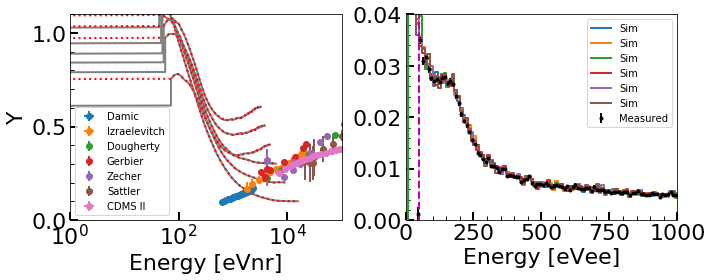

In [200]:
import R68_plot_tools as pt

fig,axs=subplots(1,2,figsize=(10,4))

#Add other measurements from lit
pt.plotOldYs(axs[0],fmt='o')

#Y=Yield.Yield('Lind',[0.146])
#axs[0].plot(E_nrs,Y.calc(E_nrs),label='Lind')

#Y=Yield.Yield('Chav',[0.146,1e3/0.247])
#axs[0].plot(E_nrs,Y.calc(E_nrs),label='Chav')

for E_nrs,Ys in zip(lE_nrs,lYs):
    axs[0].plot(E_nrs,Ys,'-',color='gray')#,label='Sim')
    
    from scipy.interpolate import CubicSpline
    cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    axs[0].plot(E_nrs,Y_fCS(E_nrs),':r')
    
#axs[0].set_xlim(0,5e3)
axs[0].set_xlim(1e0,1e5);
axs[0].set_xscale('log')
axs[0].set_ylim(0,1.1)
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
axs[0].legend()

axs[1].errorbar(Ebin_ctr,R_meas,dR_meas, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')


for E_nrs,Ys,fer,fnr in zip(lE_nrs,lYs,lfer,lfnr):
    cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    
    
    C_er,_=np.histogram(E_er,bins=Ebins)
    R_er=fer*C_er/tlive_er
    Y=Yield.Yield('User',[Y_fCS])
    C_nr,_=np.histogram(NRtoER(E_nr,Y,V,eps),bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(NRtoER(E_ng,Y,V,eps),bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

    #axs[1].step(Ebin_ctr,R_er,where='mid')
    #axs[1].step(Ebin_ctr,R_nr,where='mid')
    #axs[1].step(Ebin_ctr,R_ng,where='mid')

    step(Ebin_ctr,R_er+R_nr+R_ng,where='mid',label='Sim')

axs[1].axvline(50,linestyle='--',color='m')

axs[1].set_ylim(0,0.04)
axs[1].set_xlim(0,1e3)
axs[1].set_xlabel('Energy [eVee]')

axs[1].legend()

tight_layout()

Alright, that seems to work for cases with fng=0. Interestingly the yield curves are all incresing to 1 and in tension with measurements. This is some evidence that we need the (n,gamma) too.
Now, to include it we need to do the smearing and iteration.

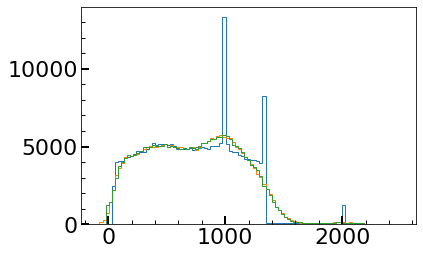

In [693]:
bins=np.linspace(-100,2500,100)
hist(E_ng,bins=bins,histtype='step');
hist(ERtoNR(spec.getSmeared(NRtoER(E_ng,0.2,V,eps)),0.2,V,eps),bins=bins,histtype='step');
#Looks like that's doing the right thing. Maybe need to truncate at 0
ERsmeared=spec.getSmeared(NRtoER(E_ng,0.2,V,eps))
ERsmeared[ERsmeared<0]=0
hist(ERtoNR(ERsmeared,0.2,V,eps),bins=bins,histtype='step');

In [694]:
Y_max=0.25
#Normalize so that ER+NR matches data near 2 keV
fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive'])
print(fg4)

E_nrs,Ys=extract_Y(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max, E_nr_step=1)
cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

plot(E_nrs,Ys,'o')
plot(E_nrs[cFit],Y_fCS(E_nrs[cFit]),'-k')

4.362611941721183


NameError: name 'extract_Y' is not defined

(-0.1, 1)

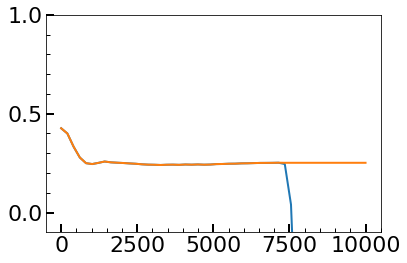

In [117]:
plot(np.linspace(0,1e4),Y_fCS(np.linspace(0,1e4)))
#Need to condition the yield fit outside of fit region
def Y_fit(E):
    y=Y_fCS(E)
    y[E>E_nrs[-1]]=Ys[-1]
    y[E<0]=0
    return y

plot(np.linspace(0,1e4),Y_fit(np.linspace(0,1e4)))
ylim(-0.1,1)

In [692]:
Y=Yield.Yield('User',[Y_fit])
#E_nr_sm=ERtoNR(spec.getSmeared(NRtoER(E_nr,Y,V,eps)),Y,V,eps)#Overflow and slow
#E_ng_sm1=ERtoNR(spec.getSmeared(NRtoER(E_ng,Y,V,eps)),Y,V,eps)
E_nr_eVee=NRtoER(E_nr,Y,V,eps)
E_ng_eVee=NRtoER(E_ng,Y,V,eps)

#Use this correspondence to map back to NR
cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
ERtoNR_fCS=CubicSpline(NRtoER(E_nrs[cFit],Y,V,eps),E_nrs[cFit])

E_nr_sm=ERtoNR_fCS(spec.getSmeared(E_nr_eVee))
E_ng_sm=ERtoNR_fCS(spec.getSmeared(E_ng_eVee))
E_ng_sm2=ERtoNR_fCS(spec.getSmeared(E_ng_eVee))

Ebnr=np.linspace(0,3e3,200)
hist(E_nr,bins=Ebnr,histtype='step');
hist(E_nr_sm,bins=Ebnr,histtype='step');

hist(E_ng,bins=Ebnr,histtype='step');
hist(E_ng_sm,bins=Ebnr,histtype='step');
hist(E_ng_sm2,bins=Ebnr,histtype='step');

#yscale('log')

ValueError: `x` must be strictly increasing sequence.

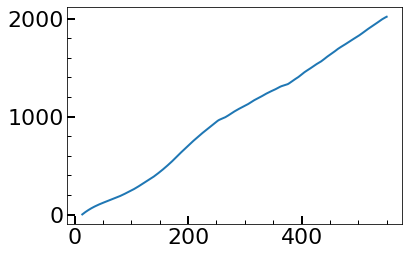

In [119]:
#c,b,_=hist(E_ng_eVee,bins=200);
#hist(spec.getSmeared(E_ng_eVee),bins=b);
plot(b,ERtoNR_fCS(b))

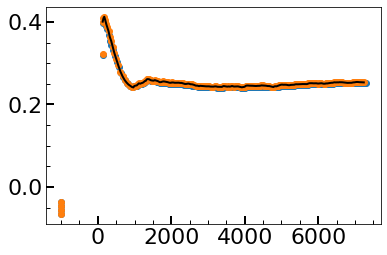

In [120]:
E_nrs_0=E_nrs
Ys_0=Ys
E_nrs,Ys=extract_Y(E_er, E_nr_sm, E_ng_sm, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max, E_nr_step=1)
cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

plot(E_nrs_0,Ys_0,'o')
plot(E_nrs,Ys,'o')
plot(E_nrs[cFit],Y_fCS(E_nrs[cFit]),'-k')

Okay, I think that covers the rough steps for this. Let's package it into a function.

In [20]:
#Extract yield curve using the integral method
#Treats each event as a single scatter of the total energy
#fer: ER livetime factor
#fnr: NR livetime factor
#fng: NG livetime factor
#Y_max: Yield value that corresponds to the highest bin edge of Ebins
tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

def extract_Y_wSmear(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, E_nr_step=1,nIt=2,verbose=True):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global Ebins,R_meas,tlive_er,tlive_nr,tlive_ng, V, eps
    
    
    #Initial yield, with no resolution effects
    E_nrs,Ys=extract_Y(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, E_nr_step, verbose)
    
    iIt=0
    while iIt<nIt:
        iIt+=1
        
        cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

        Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[0],0,E_nrs[-1],Ys[-1])
        Y=Yield.Yield('User',[Y_fit])
        #E_nr_sm=ERtoNR(spec.getSmeared(NRtoER(E_nr,Y,V,eps)),Y,V,eps)#Overflow and slow
        #E_ng_sm1=ERtoNR(spec.getSmeared(NRtoER(E_ng,Y,V,eps)),Y,V,eps)
        
        E_nr_eVee=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee=NRtoER(E_ng,Y,V,eps)

        #Use this correspondence to map back to NR
        cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        ERtoNR_fCS=CubicSpline(NRtoER(E_nrs[cFit],Y,V,eps),E_nrs[cFit])

        E_er_sm=spec.getSmeared(E_er)
        E_er_sm[E_er_sm<0]=0
        E_nr_sm=ERtoNR_fCS(spec.getSmeared(E_nr_eVee))
        E_nr_sm[E_nr_sm<0]=0
        E_ng_sm=ERtoNR_fCS(spec.getSmeared(E_ng_eVee))
        E_ng_sm[E_ng_sm<0]=0
        
        E_nrs,Ys=extract_Y(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, E_nr_step, verbose)
        
    return (E_nrs,Ys)

def Y_conditioned(E, Y_fCS, Emin, Ymin, Emax, Ymax):
    y=Y_fCS(E)
    y[E>=Emax]=Ymax
    y[E<=Emin]=Ymin
    return y

4.362611941721183


(0, 1)

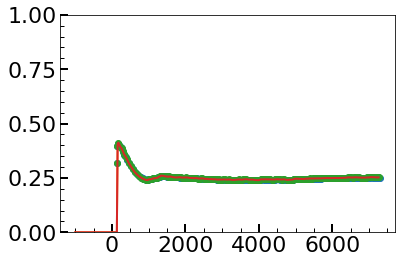

In [543]:
Y_max=0.25
#Normalize so that ER+NR matches data near 2 keV
fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive'])
print(fg4)

E_nrs,Ys=extract_Y(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max, E_nr_step=1)
plot(E_nrs,Ys,'o')
 
cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[E_nrs>0][0],0,E_nrs[-1],Ys[-1])
plot(E_nrs,Y_fit(E_nrs),'-')

E_nrs,Ys=extract_Y_wSmear(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max, nIt=1, E_nr_step=1)
plot(E_nrs,Ys,'o')

cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[E_nrs>0][0],0,E_nrs[-1],Ys[-1])
plot(E_nrs,Y_fit(E_nrs),'-')
ylim(0,1)

In [544]:
#lY_max=np.linspace(0.1,0.5,5)
lY_max=[0.3]
lfer=[]
lfnr=[]
lfng=[]
lE_nrs=[]
lYs=[]
for Y_max in tqdm(lY_max):
    #Normalize so that ER+NR matches data near 2 keV
    fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive'])
    print(fg4)
    lfer.append(fg4)
    lfnr.append(fg4)
    lfng.append(1)
    E_nrs,Ys=extract_Y_wSmear(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max,
                              nIt=1, E_nr_step=1, verbose=False)
    lE_nrs.append(E_nrs)
    lYs.append(Ys)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)

4.400976619600641



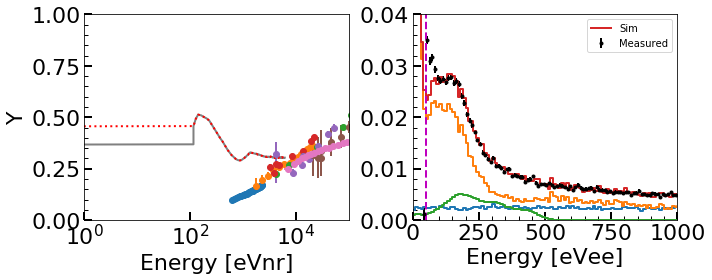

In [545]:
fig,axs=subplots(1,2,figsize=(10,4))

#Add other measurements from lit
pt.plotOldYs(axs[0],fmt='o')

for E_nrs,Ys in zip(lE_nrs,lYs):
    axs[0].plot(E_nrs,Ys,'-',color='gray')#,label='Sim')
    
#axs[0].set_xlim(0,5e3)
axs[0].set_xlim(1e0,1e5);
axs[0].set_xscale('log')
axs[0].set_ylim(0,1)
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
#axs[0].legend()

axs[1].errorbar(Ebin_ctr,R_meas,dR_meas, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')


for E_nrs,Ys,fer,fnr,fng in zip(lE_nrs,lYs,lfer,lfnr,lfng):
    cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    
    #Smear
    Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[0],0,E_nrs[-1],Ys[-1])
    Y=Yield.Yield('User',[Y_fit])
    axs[0].plot(E_nrs,Y.calc(E_nrs),':r')
    
    #E_er_sm=E_er
    #E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
    #E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)
    E_er_sm=spec.getSmeared(E_er)
    E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps))
    E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps))
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

    axs[1].step(Ebin_ctr,R_er,where='mid')
    axs[1].step(Ebin_ctr,R_nr,where='mid')
    axs[1].step(Ebin_ctr,R_ng,where='mid')

    step(Ebin_ctr,R_er+R_nr+R_ng,where='mid',label='Sim')

axs[1].axvline(50,linestyle='--',color='m')

axs[1].set_ylim(0,0.04)
axs[1].set_xlim(0,1e3)
axs[1].set_xlabel('Energy [eVee]')

axs[1].legend()

tight_layout()

With smearing tunred on, there are some deviations in the final spectrum at low energy. Gets better with a smaller E_nr_step, but calcs are taking a while. Let's do this a better way.

In [1057]:
Y_max=0.3

R0_meas=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)])
R0_er=Nint(E_er,1.9e3,2e3)/g4['ER']['tlive']
R0_nr=Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

#fg4= R0_meas/(R0_er+R0_nr)
#fer=fg4
#fnr=fg4
#fng=1

fer=0
fnr=(R0_meas)/R0_nr
fng=0

E_er_max=2e3
E_nr_max=ERtoNR(E_er_max,Y_max,V,eps)

Ebin_ctr_rev=Ebin_ctr[::-1]

rev_csum_meas=np.cumsum(R_meas[::-1])

R_sim_er=fer*np.histogram(E_er,Ebins)[0]/tlive_er
rev_csum_er=np.cumsum(R_sim_er[::-1])

w_nr=fnr/tlive_nr*np.ones(np.sum(E_nr<=E_nr_max))
w_ng=fng/tlive_ng*np.ones(np.sum(E_ng<=E_nr_max))

E_nrng=np.concatenate((E_nr[E_nr<=E_nr_max],E_ng[E_ng<=E_nr_max]))
w_nrng=np.concatenate((w_nr,w_ng))

E_nrng_rev_srt=(E_nrng[np.argsort(E_nrng)])[::-1]
w_nrng_rev_srt=(w_nrng[np.argsort(E_nrng)])[::-1]
rev_csum_nrng=np.cumsum(w_nrng_rev_srt)

diff=rev_csum_meas-rev_csum_er
E_nrs=[]
error=[]
for entry in diff:
    if np.isfinite(entry):
        args=np.argwhere(rev_csum_nrng>=entry)
        if len(args)==0:
            E_nrs.append(-99)
        else:
            E_nr_this=E_nrng_rev_srt[args[0][0]]
            error.append(rev_csum_nrng[args[0][0]]-entry)
            if len(E_nrs)>0:
                E_nrs.append(min(E_nr_this,E_nrs[-1]))
            else:
                E_nrs.append(E_nr_this)
    else:
        E_nrs.append(-999)
        error.append(-999)
E_nrs=np.array(E_nrs[::-1])
Ys=((Ebins[:-1]/E_nrs)*(1+V/eps)-1)*eps/V

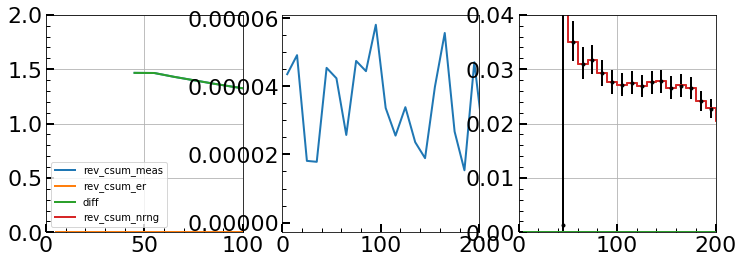

In [1058]:
figure(figsize=(12,4))
subplot(1,3,1)
plot(Ebin_ctr_rev,rev_csum_meas,label='rev_csum_meas')
plot(Ebin_ctr_rev,rev_csum_er,label='rev_csum_er')
plot(Ebin_ctr_rev,diff,label='diff')
plot(E_nrng_rev_srt,rev_csum_nrng,label='rev_csum_nrng')
#plot(E_nrs,Ys,'o')
legend()
xlim(0,100)
ylim(0,2)
grid()

subplot(1,3,2)
#plot(Ebin_ctr,E_nrs)

cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

#Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[0],0,E_nrs[-1],Ys[-1])
Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
Y=Yield.Yield('User',[Y_fit])

#plot(E_nrs,Ys,'-o')
#plot(E_nrs,Y.calc(E_nrs),':r')
#plot(E_nrs[:-10],error[:-10])
plot(Ebin_ctr[:-10],error[:-10])
#plot(E_nrs,Ebin_ctr)
xlim(0,200)
#ylim(-1e-3,1e-3)

subplot(1,3,3)
errorbar(Ebin_ctr,R_meas,dR_meas, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')

E_er_sm=E_er
E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)

C_er,_=np.histogram(E_er_sm,bins=Ebins)
R_er=fer*C_er/tlive_er
C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
R_nr=fnr*C_nr/tlive_nr
C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
R_ng=fng*C_ng/tlive_ng

step(Ebin_ctr,R_er,where='mid',label='ER')
step(Ebin_ctr,R_nr,where='mid',label='NR')
step(Ebin_ctr,R_ng,where='mid',label='(n,gamma)')
step(Ebin_ctr,R_er+R_nr+R_ng,where='mid',label='Sim')

ylim(0,0.04)
xlim(0,200)
grid()

In [1059]:
print(Y.calc(50))

E_nr_eVee=NRtoER(E_nr,Y,V,eps)
E_ng_eVee=NRtoER(E_ng,Y,V,eps)

#Use this correspondence to map back to NR
#But need to condition it outside of the spline region.
#Just extrapolate with linear from each end
xx=NRtoER(E_nrs[cFit],Y,V,eps)
yy=E_nrs[cFit]
ERtoNR_fCS=CubicSpline(xx,yy,extrapolate=True)
pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))
pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
ERtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fCS(E) + (E>xx[-1])*pf_hi(E)

E_er_sm=spec.getSmeared(E_er,seed=None,F=F)
E_er_sm[E_er_sm<0]=0
#E_er_sm=E_er
E_nr_sm=ERtoNR_fcombo(spec.getSmeared(E_nr_eVee,seed=None,F=F))
#E_nr_sm[E_nr_sm<0]=0
#E_nr_sm=E_nr
E_ng_sm=ERtoNR_fcombo(spec.getSmeared(E_ng_eVee,seed=None,F=F))
#E_ng_sm[E_ng_sm<0]=0

0.11253854593099594


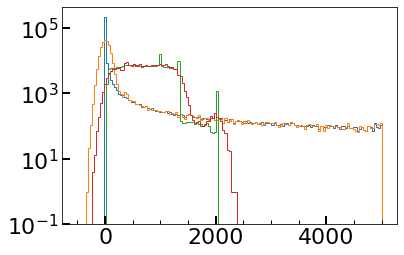

In [1060]:
#hist(spec.getSmeared(E_nr_eVee,seed=None,F=F),bins=np.linspace(-50,2e3,200),log=True);
hist(E_nr,bins=np.linspace(-500,5e3,150),log=True,histtype='step');
hist(E_nr_sm,bins=np.linspace(-500,5e3,150),log=True,histtype='step');

hist(E_ng,bins=np.linspace(-500,5e3,150),log=True,histtype='step');
hist(E_ng_sm,bins=np.linspace(-500,5e3,150),log=True,histtype='step');

In [1061]:
E_nrs,Ys,errors=extract_Y_v2(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, Ebins)

cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

#Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[0],0,E_nrs[-1],Ys[-1])
Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
Y=Yield.Yield('User',[Y_fit])

print(Y.calc(50))

E_nr_eVee=NRtoER(E_nr,Y,V,eps)
E_ng_eVee=NRtoER(E_ng,Y,V,eps)

#Use this correspondence to map back to NR
#But need to condition it outside of the spline region.
#Just extrapolate with linear from each end
xx=NRtoER(E_nrs[cFit],Y,V,eps)
yy=E_nrs[cFit]
ERtoNR_fCS=CubicSpline(xx,yy,extrapolate=True)
pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))
pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
ERtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fCS(E) + (E>xx[-1])*pf_hi(E)

E_er_sm2=spec.getSmeared(E_er,seed=None,F=F)
#E_er_sm[E_er_sm<0]=0
#E_er_sm=E_er
E_nr_sm2=ERtoNR_fcombo(spec.getSmeared(E_nr_eVee,seed=None,F=F))
#E_nr_sm[E_nr_sm<0]=0
#E_nr_sm=E_nr
E_ng_sm2=ERtoNR_fcombo(spec.getSmeared(E_ng_eVee,seed=None,F=F))


1.4664985744157613,0.0,15.031367682745751,0.0
0.10550878893168458


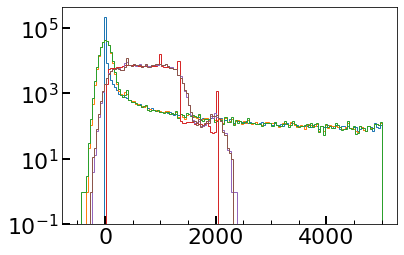

In [1062]:
#hist(spec.getSmeared(E_nr_eVee,seed=None,F=F),bins=np.linspace(-50,2e3,200),log=True);
hist(E_nr,bins=np.linspace(-500,5e3,150),log=True,histtype='step');
hist(E_nr_sm,bins=np.linspace(-500,5e3,150),log=True,histtype='step');
hist(E_nr_sm2,bins=np.linspace(-500,5e3,150),log=True,histtype='step');

hist(E_ng,bins=np.linspace(-500,5e3,150),log=True,histtype='step');
hist(E_ng_sm,bins=np.linspace(-500,5e3,150),log=True,histtype='step');
hist(E_ng_sm2,bins=np.linspace(-500,5e3,150),log=True,histtype='step');

In [1063]:
E_nrs,Ys,errors=extract_Y_v2(E_er_sm2, E_nr_sm2, E_ng_sm2, fer, fnr, fng, Y_max, Ebins)

cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

#Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[0],0,E_nrs[-1],Ys[-1])
Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
Y=Yield.Yield('User',[Y_fit])

print(Y.calc(50))

E_nr_eVee=NRtoER(E_nr,Y,V,eps)
E_ng_eVee=NRtoER(E_ng,Y,V,eps)

#Use this correspondence to map back to NR
#But need to condition it outside of the spline region.
#Just extrapolate with linear from each end
xx=NRtoER(E_nrs[cFit],Y,V,eps)
yy=E_nrs[cFit]
ERtoNR_fCS=CubicSpline(xx,yy,extrapolate=True)
pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))
pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
ERtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fCS(E) + (E>xx[-1])*pf_hi(E)

E_er_sm3=spec.getSmeared(E_er,seed=None,F=F)
#E_er_sm[E_er_sm<0]=0
#E_er_sm=E_er
E_nr_sm3=ERtoNR_fcombo(spec.getSmeared(E_nr_eVee,seed=None,F=F))
#E_nr_sm[E_nr_sm<0]=0
#E_nr_sm=E_nr
E_ng_sm3=ERtoNR_fcombo(spec.getSmeared(E_ng_eVee,seed=None,F=F))

1.4664985744157613,0.0,15.028927950004942,0.0
0.10332481646328684


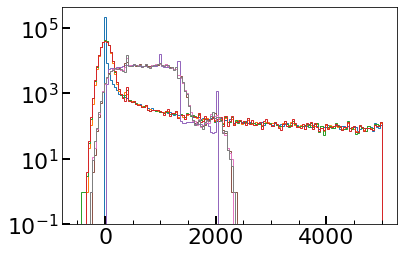

In [1064]:
#hist(spec.getSmeared(E_nr_eVee,seed=None,F=F),bins=np.linspace(-50,2e3,200),log=True);
hist(E_nr,bins=np.linspace(-500,5e3,150),log=True,histtype='step');
hist(E_nr_sm,bins=np.linspace(-500,5e3,150),log=True,histtype='step');
hist(E_nr_sm2,bins=np.linspace(-500,5e3,150),log=True,histtype='step');
hist(E_nr_sm3,bins=np.linspace(-500,5e3,150),log=True,histtype='step');

hist(E_ng,bins=np.linspace(-500,5e3,150),log=True,histtype='step');
hist(E_ng_sm,bins=np.linspace(-500,5e3,150),log=True,histtype='step');
hist(E_ng_sm2,bins=np.linspace(-500,5e3,150),log=True,histtype='step');
hist(E_ng_sm3,bins=np.linspace(-500,5e3,150),log=True,histtype='step');

In [1069]:
print(np.sum((E_nr>400)&(E_nr<4e3)))
print(np.sum((E_nr_sm>400)&(E_nr_sm<4e3)))
print(np.sum((E_nr_sm2>400)&(E_nr_sm2<4e3)))
print(np.sum((E_nr_sm3>400)&(E_nr_sm3<4e3)))

19128
19266
19305
19270


(0, 0.25)

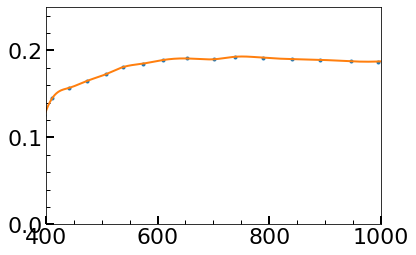

In [1056]:
plot(E_nrs,Ys,'.')
plot(np.linspace(0,1e3,1000),Y.calc(np.linspace(0,1e3,1000)))
xlim(400,1e3)
ylim(0,0.25)

In [1001]:
E_nrs,Ys,errors=extract_Y_v2(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, Ebins)

cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

#Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[0],0,E_nrs[-1],Ys[-1])
Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
Y=Yield.Yield('User',[Y_fit])

print(Y.calc(50))


1.4664985744157613,0.0,15.032239015867468,0.0
0.10337027392995092


In [1180]:
def extract_Y_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, Ebins=None, verbose=True):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global tlive_er,tlive_nr,tlive_ng, V, eps
    
    if Ebins is None:
        Ebins=np.linspace(0,2e3,201)
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    
    R_meas,dR_meas=spec.doBkgSub(meas, Ebins, Efit_min=50,Efit_max=2e3,
                                 doEffsyst=False, doBurstLeaksyst=False,
                                 output='reco-rate')
    
    E_er_max=Ebins[-1]
    E_nr_max=ERtoNR(E_er_max,Y_max,V,eps)

    Ebin_ctr_rev=Ebin_ctr[::-1]

    rev_csum_meas=np.cumsum(R_meas[::-1])

    R_sim_er=fer*np.histogram(E_er,Ebins)[0]/tlive_er
    rev_csum_er=np.cumsum(R_sim_er[::-1])

    w_nr=fnr/tlive_nr*np.ones(np.sum(E_nr<=E_nr_max))
    w_ng=fng/tlive_ng*np.ones(np.sum(E_ng<=E_nr_max))
    if verbose:
        print(f'{np.max(rev_csum_meas[np.isfinite(rev_csum_meas)])},{np.max(rev_csum_er)},{np.sum(w_nr)},{np.sum(w_ng)}')
        
    E_nrng=np.concatenate((E_nr[E_nr<=E_nr_max],E_ng[E_ng<=E_nr_max]))
    w_nrng=np.concatenate((w_nr,w_ng))

    E_nrng_rev_srt=(E_nrng[np.argsort(E_nrng)])[::-1]
    w_nrng_rev_srt=(w_nrng[np.argsort(E_nrng)])[::-1]
    rev_csum_nrng=np.cumsum(w_nrng_rev_srt)

    diff=rev_csum_meas-rev_csum_er
    E_nrs=[]
    error=[]
    for entry in diff:
        if np.isfinite(entry):
            args=np.argwhere(rev_csum_nrng>=entry)
            if len(args)==0:
                E_nrs.append(-99)
            else:
                E_nr_this=E_nrng_rev_srt[args[0][0]]
                error.append(rev_csum_nrng[args[0][0]]-entry)
                if len(E_nrs)>0:
                    E_nrs.append(min(E_nr_this,E_nrs[-1]))
                else:
                    E_nrs.append(E_nr_this)
        else:
            E_nrs.append(-999)
            error.append(-999)
    E_nrs=np.array(E_nrs[::-1])
    Ys=((Ebins[:-1]/E_nrs)*(1+V/eps)-1)*eps/V
    error=np.array(error)
    
    return (E_nrs,Ys,error)

#Extract yield curve using the integral method
#Treats each event as a single scatter of the total energy
#fer: ER livetime factor
#fnr: NR livetime factor
#fng: NG livetime factor
#Y_max: Yield value that corresponds to the highest bin edge of Ebins
tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']
from scipy.interpolate import CubicSpline

def extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, nIt=2, F=0, Ebins=None, seed=None, verbose=True):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global tlive_er,tlive_nr,tlive_ng, V, eps
    
    if Ebins is None:
        Ebins=np.linspace(0,2e3,201)
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    
    #Initial yield, with no resolution effects
    E_nrs,Ys,errors=extract_Y_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, Ebins, verbose)
    
    iIt=0
    while iIt<nIt:
        iIt+=1
        
        if verbose:
            print('Smearing ',iIt)
            
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        #Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
        
        Y_fCS=lambda E: np.interp(E,E_nrs[cFit],Ys[cFit])

        #Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[0],0,E_nrs[-1],Ys[-1])
        #Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
        Y_fit = lambda E: Y_conditioned_test(E,Y_fCS,E_nrs[cFit],Ys[cFit])
        Y=Yield.Yield('User',[Y_fit])
        #Overflow and slow
        #E_nr_sm=ERtoNR(spec.getSmeared(NRtoER(E_nr,Y,V,eps)),Y,V,eps)
        #E_ng_sm=ERtoNR(spec.getSmeared(NRtoER(E_ng,Y,V,eps)),Y,V,eps)
        
        E_nr_eVee=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee=NRtoER(E_ng,Y,V,eps)

        #Use this correspondence to map back to NR
        #But need to condition it outside of the spline region.
        #Just extrapolate with linear from each end
        xx=NRtoER(E_nrs[cFit],Y,V,eps)
        yy=E_nrs[cFit]
        #ERtoNR_fCS=CubicSpline(xx,yy,extrapolate=True)
        ERtoNR_fCS=lambda E: np.interp(E,xx,yy)
        pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))
        pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
        ERtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fCS(E) + (E>xx[-1])*pf_hi(E)

        E_er_sm=spec.getSmeared(E_er,seed=seed,F=F)
        E_er_sm[E_er_sm<0]=0

        E_nr_sm=ERtoNR_fcombo(spec.getSmeared(E_nr_eVee,seed=seed,F=F))
        E_nr_sm[E_nr_sm<0]=0

        E_ng_sm=ERtoNR_fcombo(spec.getSmeared(E_ng_eVee,seed=seed,F=F))
        E_ng_sm[E_ng_sm<0]=0
        
        if verbose:
            print('E_nr_sm[:5] = ',E_nr_sm[:5])
        E_nrs,Ys,errors=extract_Y_v2(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, Ebins, verbose)
        
    return (E_nrs,Ys,errors)

def Y_conditioned(E, Y_fCS, Emin, Ymin, Emax, Ymax):
    y=Y_fCS(E)
    y[E>=Emax]=Ymax
    y[E<=Emin]=Ymin
    return y

def Y_conditioned_test(E, Y_fCS, E_nrs_fit, Ys_fit):
    y=Y_fCS(E)
    
    ylow=np.poly1d(np.polyfit(E_nrs_fit[:2],Ys_fit[:2], 1))
    y[E<=E_nrs_fit[0]]=ylow(E[E<=E_nrs_fit[0]])
    #y[E<=E_nrs_fit[0]]=Ys_fit[0]
    
    yhi=np.poly1d(np.polyfit(E_nrs_fit[-2:],Ys_fit[-2:], 1))
    y[E>=E_nrs_fit[-1]]=yhi(E[E>=E_nrs_fit[-1]])
    #y[E>=E_nrs_fit[-1]]=Ys_fit[-1]
    
    y[y<0]=0
    return y

In [1192]:
#lY_max=np.concatenate((np.linspace(0.2,0.3,5),np.linspace(0.2,0.3,5)))
lY_max=np.linspace(0.2,0.3,5)
#lfng=np.linspace(0,5,6)
#lY_max=0.25*np.ones_like(lfng)
lfer=[]
lfnr=[]
#lfng=np.concatenate(((2.037+0.408)*np.ones(5),(2.037-0.408)*np.ones(5)))
lfng=[]
lE_nrs=[]
lYs=[]
lerrors=[]

for Y_max in tqdm(lY_max):
#for Y_max,fng in tqdm(zip(lY_max,lfng)):
#for fng in tqdm(lfng):
    #Y_max=lY_max[0]
    #Normalize so that ER+NR matches data near 2 keV

    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

    #R0_meas=np.sum(R_meas[(Ebin_ctr>9e3)&(Ebin_ctr<10e3)])
    #R0_er=Nint(E_er,9e3,10e3)/g4['ER']['tlive']
    #R0_nr=Nint(E_nr,ERtoNR(9e3,Y_max,V,eps),ERtoNR(10e3,Y_max,V,eps))/g4['NR']['tlive']


    #fg4= R0_meas/(R0_er+R0_nr)
    #fer=fg4
    #fnr=fg4
    #fng=1

    #fer=1
    #fnr=(R0_meas-fer*R0_er)/R0_nr
    #fng=2.037

    fnr=6
    fer=(R0_meas-fnr*R0_nr)/R0_er
    fng=2#2.037

    print(fer,fnr,fng)
    lfer.append(fer)
    lfnr.append(fnr)
    lfng.append(fng)
    E_nrs,Ys,errors=extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                              nIt=1, Ebins=np.linspace(0,2e3,201), seed=None, verbose=False)
    #If binning is too small, will get some errors and things won't work.
    #Probably in bkg_sub, but not exactly sure
    lE_nrs.append(E_nrs)
    lYs.append(Ys)
    lerrors.append(errors)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)
lerrors=np.array(lerrors)

2.4100583801222495 6 2
3.3868025661687606 6 2
3.1077327987269 6 2
3.805407217331551 6 2
4.433314194075737 6 2



/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


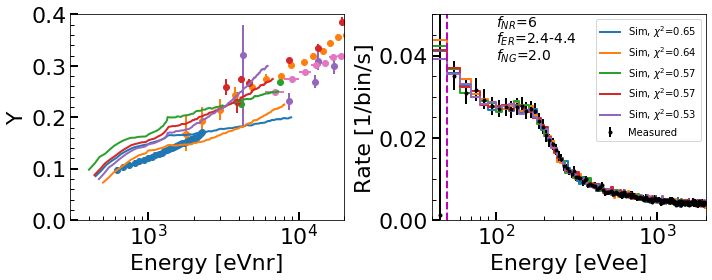

In [1194]:
fig,axs=subplots(1,2,figsize=(10,4))
dosmear=True
seed=None

#Add other measurements from lit
import R68_plot_tools as pt
pt.plotOldYs(axs[0],fmt='o')

axs[1].text(1e2,0.047,r'$f_{NR}$'+f'={np.min(lfnr)}',size=14)
axs[1].text(1e2,0.043,r'$f_{ER}$'+f'={np.min(lfer):.1f}-{np.max(lfer):.1f}',size=14)
axs[1].text(1e2,0.039,r'$f_{NG}$'+f'={np.min(lfng):.1f}',size=14)

axs[1].errorbar(Ebin_ctr,R_meas,dR_meas, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')

axs[0].set_prop_cycle(None)#Reset color cycle
axs[1].set_prop_cycle(None)

for E_nrs,Ys,fer,fnr,fng in zip(lE_nrs,lYs,lfer,lfnr,lfng):
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    Y_fCS=lambda E: np.interp(E,E_nrs[cFit],Ys[cFit])
    axs[0].plot(E_nrs[cFit],Ys[cFit],'-',zorder=3)#,color='gray')#,label='Sim')
    
    #Smear
    #Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
    Y_fit = lambda E: Y_conditioned_test(E,Y_fCS,E_nrs[cFit],Ys[cFit])
    Y=Yield.Yield('User',[Y_fit])
    #axs[0].plot(E_nrs,Y.calc(E_nrs),':k',zorder=10)
    
    if dosmear:
        E_er_sm=spec.getSmeared(E_er,seed=seed)
        E_er_sm[E_er_sm<0]=0
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed)
        E_nr_eVee_sm[E_nr_eVee_sm<0]=0
        E_nr_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed)
        E_ng_eVee_sm[E_ng_eVee_sm<0]=0
        #print('E_nr_eVee_sm[:5] = ',E_nr_eVee_sm[:5])
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

    #axs[1].step(Ebin_ctr,R_er,where='mid',label='ER')
    #axs[1].step(Ebin_ctr,R_nr,where='mid',label='NR')
    #axs[1].step(Ebin_ctr,R_ng,where='mid')#,label='(n,gamma)')
    R_tot=R_er+R_nr+R_ng
    chi=np.mean((((R_tot-R_meas)/((dR_meas[0]+dR_meas[1])/2))**2)[Ebin_ctr>50])
    step(Ebin_ctr,R_tot,where='mid',label=r'Sim, $\chi^2$='+f'{chi:.2g}')



#axs[0].set_xlim(0,5e2)
axs[0].set_xlim(3e2,2e4);
axs[0].set_xscale('log')
axs[0].set_ylim(0,0.4)
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
#axs[0].legend()

axs[1].axvline(50,linestyle='--',color='m')

axs[1].set_ylim(0,0.05)
axs[1].set_xlim(40,2e3)
axs[1].set_xscale('log')
#axs[1].set_xlim(0,250)
axs[1].set_xlabel('Energy [eVee]')
axs[1].set_ylabel('Rate [1/bin/s]')

axs[1].legend()

tight_layout()

# Smearing Iteration Comparison

In [1181]:
#lnIt=np.arange(11)
lnIt=[0,1,2,5,10,15,20,30]
lY_max=[]
lfer=[]
lfnr=[]
lfng=[]
lE_nrs=[]
lYs=[]
lerrors=[]

for nIt in tqdm(lnIt):

    Y_max=0.25
    
    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']
    
    
    lY_max.append(Y_max)
    fnr=6
    fer=(R0_meas-fnr*R0_nr)/R0_er
    fng=4#2.037+0.41

    print(fer,fnr,fng)
    lfer.append(fer)
    lfnr.append(fnr)
    lfng.append(fng)
    E_nrs,Ys,errors=extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                              nIt=nIt, Ebins=np.linspace(0,2e3,201), seed=None, verbose=False)
    #If binning is too small, will get some errors and things won't work.
    #Probably in bkg_sub, but not exactly sure
    lE_nrs.append(E_nrs)
    lYs.append(Ys)
    lerrors.append(errors)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)
lerrors=np.array(lerrors)

3.1077327987269 6 4
3.1077327987269 6 4
3.1077327987269 6 4
3.1077327987269 6 4
3.1077327987269 6 4
3.1077327987269 6 4
3.1077327987269 6 4
3.1077327987269 6 4



/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


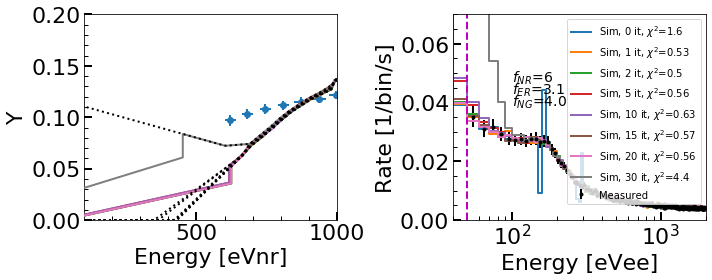

In [1183]:
fig,axs=subplots(1,2,figsize=(10,4))
dosmear=True
seed=None

#Add other measurements from lit
import R68_plot_tools as pt
pt.plotOldYs(axs[0],fmt='o')

axs[1].text(1e2,0.047,r'$f_{NR}$'+f'={np.min(lfnr)}',size=14)
axs[1].text(1e2,0.043,r'$f_{ER}$'+f'={np.min(lfer):.1f}',size=14)
axs[1].text(1e2,0.039,r'$f_{NG}$'+f'={np.min(lfng):.1f}',size=14)

axs[1].errorbar(Ebin_ctr[Ebin_ctr>50],R_meas[Ebin_ctr>50],(dR_meas.T[Ebin_ctr>50]).T, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')

axs[0].set_prop_cycle(None)#Reset color cycle
axs[1].set_prop_cycle(None)

for E_nrs,Ys,fer,fnr,fng,nIt in zip(lE_nrs,lYs,lfer,lfnr,lfng,lnIt):
    
    cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    #Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    Y_fCS=lambda E: np.interp(E,E_nrs[cFit],Ys[cFit])
    
    axs[0].plot(E_nrs,Ys,'-',zorder=3)#,color='gray')#,label='Sim')
    
    #Smear
    #Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
    Y_fit = lambda E: Y_conditioned_test(E,Y_fCS,E_nrs[cFit],Ys[cFit])
    
    Y=Yield.Yield('User',[Y_fit])
    
    #axs[0].plot(E_nrs,Y.calc(E_nrs),':k',zorder=10)
    axs[0].plot(np.linspace(0,E_nrs[-1],1000),Y.calc(np.linspace(0,E_nrs[-1],1000)),':k',zorder=10)
    
    if nIt>0:
        E_er_sm=spec.getSmeared(E_er,seed=seed)
        E_er_sm[E_er_sm<0]=0
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed)
        E_nr_eVee_sm[E_nr_eVee_sm<0]=0
        E_nr_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed)
        E_ng_eVee_sm[E_ng_eVee_sm<0]=0
        #print('E_nr_eVee_sm[:5] = ',E_nr_eVee_sm[:5])
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

    #axs[1].step(Ebin_ctr,R_er,where='mid',label='ER')
    #axs[1].step(Ebin_ctr,R_nr,where='mid',label='NR')
    #axs[1].step(Ebin_ctr,R_ng,where='mid')#,label='(n,gamma)')
    R_tot=R_er+R_nr+R_ng
    chi=np.mean((((R_tot-R_meas)/((dR_meas[0]+dR_meas[1])/2))**2)[Ebin_ctr>50])
    #step(Ebin_ctr,R_tot,where='mid',label=r'Sim, $\chi^2$='+f'{chi:.2g}')#+' fng='+str(fng))
    step(Ebin_ctr,R_tot,where='mid',label=f'Sim, {nIt} it, '+r'$\chi^2$='+f'{chi:.2g}')


axs[0].set_xlim(100,1e3)
#axs[0].set_xlim(3e2,2e4);
#axs[0].set_xscale('log')
axs[0].set_ylim(0,0.2)
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
#axs[0].legend()

axs[1].axvline(50,linestyle='--',color='m')

axs[1].set_ylim(0,0.07)
axs[1].set_xlim(40,2e3)
axs[1].set_xscale('log')
#axs[1].set_xlim(0,250)
axs[1].set_xlabel('Energy [eVee]')
axs[1].set_ylabel('Rate [1/bin/s]')

axs[1].legend(loc='upper right')

tight_layout()

(600, 950)

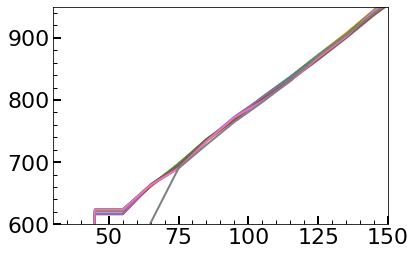

In [1188]:
for E_nrs,Ys,fer,fnr,fng,nIt in zip(lE_nrs,lYs,lfer,lfnr,lfng,lnIt):
    plot(Ebin_ctr,E_nrs,'-')
    #print(E_nrs[3:10])
xlim(30,150)
ylim(600,950)
#xscale('log')

(0, 0.1)

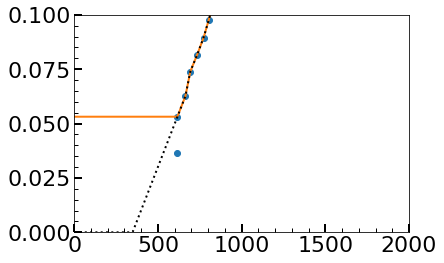

In [1186]:
E_nrs=lE_nrs[4]
Ys=lYs[4]

plot(E_nrs,Ys,'o')

cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
Y_fCS=lambda E: np.interp(E,E_nrs[cFit],Ys[cFit])
plot(np.linspace(0,E_nrs[-1],1000),Y_fCS(np.linspace(0,E_nrs[-1],1000)))

#Smear
Y_fit = lambda E: Y_conditioned_test(E,Y_fCS,E_nrs[cFit],Ys[cFit])
Y=Yield.Yield('User',[Y_fit])
#plot(E_nrs,Y.calc(E_nrs),':k',zorder=10)
plot(np.linspace(0,E_nrs[-1],1000),Y.calc(np.linspace(0,E_nrs[-1],1000)),':k',zorder=10)

#plot(E_nrs,Y_conditioned_test(E_nrs, Y_fCS, E_nrs[cFit],Ys[cFit]))

xlim(0,2e3)
ylim(0,0.1)

# Plot with systematic range of NG scaling

In [390]:
lY_max=np.concatenate((np.linspace(0.2,0.3,5),np.linspace(0.2,0.3,5)))
lfer=[]
lfnr=[]
lfng=np.concatenate(((2.037+0.408)*np.ones(5),(2.037-0.408)*np.ones(5)))
lE_nrs=[]
lYs=[]
lerrors=[]

for Y_max,fng in zip(tqdm(lY_max),lfng):
    #Normalize near 2keV
    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']
    
    #Try smearing here too so fits are less sensitive to these few top bins
    #R0_er=Nint(spec.getSmeared(E_er,F=F),1.99e3,2e3)/g4['ER']['tlive']
    #R0_nr=Nint(spec.getSmeared(NRtoER(E_nr,Y_max,V,eps),F=F),1.99e3,2e3)/g4['NR']['tlive']

    fer=(R0_meas)/(R0_er+R0_nr)
    fnr=fer
    
    #fer=1
    #fnr=(R0_meas-fer*R0_er)/R0_nr
    
    #fnr=1
    #fer=(R0_meas-fnr*R0_nr)/R0_er

    print(fer,fnr,fng)
    lfer.append(fer)
    lfnr.append(fnr)
    
    E_nrs,Ys,errors=extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                              nIt=1, Ebins=np.linspace(0,2e3,201), seed=0, verbose=False)
    #If binning is too small, will get some errors and things won't work.
    #Probably in bkg_sub, but not exactly sure
    lE_nrs.append(E_nrs)
    lYs.append(Ys)
    lerrors.append(errors)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)
lerrors=np.array(lerrors)

4.225661038451227 4.225661038451227 2.445
4.595406379315709 4.595406379315709 2.445
4.483323296893374 4.483323296893374 2.445
4.774448186302035 4.774448186302035 2.445
5.070793246141472 5.070793246141472 2.445
4.225661038451227 4.225661038451227 1.629
4.595406379315709 4.595406379315709 1.629
4.483323296893374 4.483323296893374 1.629
4.774448186302035 4.774448186302035 1.629
5.070793246141472 5.070793246141472 1.629



/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide


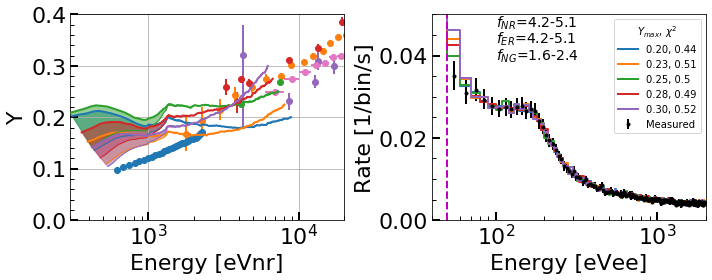

In [391]:
fig,axs=subplots(1,2,figsize=(10,4))
dosmear=True
seed=0

#Add other measurements from lit
import R68_plot_tools as pt
pt.plotOldYs(axs[0],fmt='o')

#Print some info
if np.min(lfnr)==np.max(lfnr):
    axs[1].text(1e2,0.047,r'$f_{NR}$'+f'={np.min(lfnr):.1f}',size=14)
else:
    axs[1].text(1e2,0.047,r'$f_{NR}$'+f'={np.min(lfnr):.1f}-{np.max(lfnr):.1f}',size=14)
if np.min(lfer)==np.max(lfer):
    axs[1].text(1e2,0.043,r'$f_{ER}$'+f'={np.min(lfer):.1f}',size=14)
else:
    axs[1].text(1e2,0.043,r'$f_{ER}$'+f'={np.min(lfer):.1f}-{np.max(lfer):.1f}',size=14)
if np.min(lfng)==np.max(lfng):
    axs[1].text(1e2,0.039,r'$f_{NG}$'+f'={np.min(lfng):.1f}',size=14)
else:
    axs[1].text(1e2,0.039,r'$f_{NG}$'+f'={np.min(lfng):.1f}-{np.max(lfng):.1f}',size=14)

axs[1].errorbar(Ebin_ctr[Ebin_ctr>50],R_meas[Ebin_ctr>50],(dR_meas.T[Ebin_ctr>50]).T, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')

axs[0].set_prop_cycle(None)#Reset color cycle
axs[1].set_prop_cycle(None)

N=len(lE_nrs)
for i in range(int(N/2)):    
    
    cFit1=(Ebin_ctr>50) &(lE_nrs[i]>0) & (np.isfinite(lE_nrs[i])) & (np.insert(np.diff(lE_nrs[i])>0,-1,True))
    E_nrs1=lE_nrs[i][cFit1]
    Ys1=lYs[i][cFit1]
    Y_fCS1=CubicSpline(E_nrs1,Ys1,extrapolate=True)
    
    cFit2=(Ebin_ctr>50) &(lE_nrs[i+int(N/2)]>0) & (np.isfinite(lE_nrs[i+int(N/2)])) & (np.insert(np.diff(lE_nrs[i+int(N/2)])>0,-1,True))
    E_nrs2=lE_nrs[i+int(N/2)][cFit2]
    Ys2=lYs[i+int(N/2)][cFit2]
    Y_fCS2=CubicSpline(E_nrs2,Ys2,extrapolate=True)
    
    line1=axs[0].plot(E_nrs1[2:],Ys1[2:],'-',linewidth=1,zorder=3)
    axs[0].plot(E_nrs2[2:],Ys2[2:],'-',linewidth=2,color=line1[0].get_color(),zorder=3)
    
    plt.sca(axs[0])
    fill(np.concatenate((E_nrs1[2:],E_nrs2[2:][::-1])),np.concatenate((Ys1[2:],Ys2[2:][::-1])),alpha=0.5,
         color=line1[0].get_color())

    
    #Smear
    
    Y_fit1 = lambda E: Y_conditioned(E,Y_fCS1,E_nrs1[0],Ys1[0],E_nrs1[-1],Ys1[-1])
    Y1=Yield.Yield('User',[Y_fit1])
    Y_fit2 = lambda E: Y_conditioned(E,Y_fCS2,E_nrs2[0],Ys2[0],E_nrs2[-1],Ys2[-1])
    Y2=Yield.Yield('User',[Y_fit2])
    
    #axs[0].plot(E_nrs,Y.calc(E_nrs),':k',zorder=10)
    
    if dosmear:
        E_er_sm=spec.getSmeared(E_er,seed=seed)
        E_er_sm[E_er_sm<0]=0
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y1,V,eps),seed=seed)
        E_nr_eVee_sm[E_nr_eVee_sm<0]=0
        E_nr_sm=NRtoER(E_nr,Y1,V,eps)
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y1,V,eps),seed=seed)
        E_ng_eVee_sm[E_ng_eVee_sm<0]=0
        #print('E_nr_eVee_sm[:5] = ',E_nr_eVee_sm[:5])
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y1,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y1,V,eps)
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=lfer[i]*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=lfnr[i]*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=lfng[i]*C_ng/tlive_ng

    #l1=axs[1].step(Ebin_ctr,R_er+R_nr+R_ng,where='mid',label='Sim')#+' fng='+str(fng))
    
    #axs[1].step(Ebin_ctr,R_er,where='mid',color=l1[0].get_color())
    #axs[1].step(Ebin_ctr,R_nr,where='mid',color=l1[0].get_color())
    #axs[1].step(Ebin_ctr,R_ng,where='mid',color=l1[0].get_color(),)#,label='(n,gamma)')
    
    R_tot=R_er+R_nr+R_ng
    chi=np.mean((((R_tot-R_meas)/((dR_meas[0]+dR_meas[1])/2))**2)[Ebin_ctr>50])
    #step(Ebin_ctr,R_tot,where='mid',label=r'Sim, $\chi^2$='+f'{chi:.2g}')#+' fng='+str(fng))
    #axs[1].step(Ebin_ctr,R_tot,where='mid',label=r'$Y_{max}$='+f'{lY_max[i]:.2f}'+r'$\chi^2$='+f'{chi:.2g}')
    axs[1].step(Ebin_ctr,R_tot,where='mid',label=f'{lY_max[i]:.2f}, {chi:.2g}')


#axs[0].set_xlim(0,5e2)
axs[0].set_xlim(3e2,2e4);
axs[0].set_xscale('log')
axs[0].set_ylim(0,0.4)
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
#axs[0].legend()
axs[0].grid()
    
axs[1].axvline(50,linestyle='--',color='m')

axs[1].set_ylim(0,0.05)
axs[1].set_xlim(40,2e3)
axs[1].set_xscale('log')
#axs[1].set_xlim(0,250)
axs[1].set_xlabel('Energy [eVee]')
axs[1].set_ylabel('Rate [1/bin/s]')

axs[1].legend(title=r'$Y_{max}$, $\chi^2$',loc='upper right')

tight_layout()
#savefig('figures/intmeth_fer_and_fnr_const_Ymax_compare.png')
#savefig('figures/intmeth_fer_1_Ymax_compare.png')
#savefig('figures/intmeth_fnr_1_Ymax_compare.png')

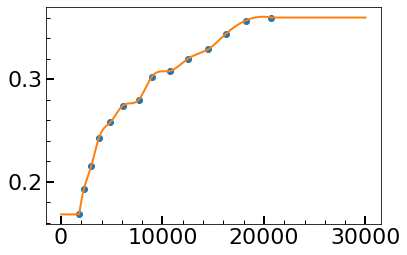

In [22]:
import R68_plot_tools as pt
izr=pt.get_old_Y_data()
plot(izr['Enr'],izr['Y'],'o')
#plot(izr['Enr'],izr['Y']+izr['dY'],'o')
Y_izr_up=CubicSpline(izr['Enr'],izr['Y'],extrapolate=True)

Y_fit = lambda E: Y_conditioned(E,Y_izr_up,izr['Enr'][0],(izr['Y'])[0],izr['Enr'][-1],(izr['Y'])[-1])
Y=Yield.Yield('User',[Y_fit])
xx=np.linspace(0,30e3,1000)
plot(xx,Y.calc(xx))

# Benchmark to other yield values

We'll also include Fano factor in this calc

In [399]:
#Let's scan through a bunch of scalings and then only retain those which are consistent with Izr

lY_max=[]
lfer=[]
lfnr=[]
lfng=[]
lE_nrs=[]
lYs=[]
lerrors=[]

for Y_max in tqdm(np.linspace(0.25,0.29,20)):
    for fnr in np.linspace(4,9,20):
        for fng in [0,2.037+0.408,2.037-0.408]:
    
            lY_max.append(Y_max)
            #Normalize near 2keV
            R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
            R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
            R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

            fer=(R0_meas-fnr*R0_nr)/R0_er

            #print(fer,fnr,fng)
            lfer.append(fer)
            lfnr.append(fnr)
            lfng.append(fng)

            E_nrs,Ys,errors=extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                                      nIt=1, Ebins=np.linspace(0,2e3,201), seed=0, F=0.1161, verbose=False)
            #If binning is too small, will get some errors and things won't work.
            #Probably in bkg_sub, but not exactly sure
            lE_nrs.append(E_nrs)
            lYs.append(Ys)
            lerrors.append(errors)

lY_max=np.array(lY_max)
lfer=np.array(lfer)
lfnr=np.array(lfnr)
lfng=np.array(lfng)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)
lerrors=np.array(lerrors)

In [402]:
#Save it
import pickle

if False:
    results={'lY_max':lY_max, 'lfer':lfer, 'lfnr':lfnr, 'lfng':lfng, 'lE_nrs':lE_nrs, 'lYs':lYs, 'lerrors':lerrors}
    with open( "data/cdf_results.p", "wb" ) as file:
        pickle.dump( results, file )
else:
    with open( "data/cdf_results.p", "rb" ) as file:
        results = pickle.load( file )
    lY_max=results['lY_max']
    lfer=results['lfer']
    lfnr=results['lfnr']
    lfng=results['lfng']
    lE_nrs=results['lE_nrs']
    lYs=results['lYs']
    lerrors=results['lerrors']

In [498]:
#TODO: use this same function every time we do this
def getYfitCond(E_nrs,Ys):
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
    return Yield.Yield('User',[Y_fit])

In [621]:
#Find those which are consistent with Izr
cgood=[]
Y_1keV=[]
for E_nrs,Ys in zip(lE_nrs,lYs):
    Y=getYfitCond(E_nrs,Ys)
    
    cizr=izr['Enr']<E_nrs[-1]
    Y_1keV.append(Y.calc(1e3))

    cgood.append(((np.abs(Y.calc(izr['Enr'])-izr['Y'])<1*izr['dY'])[cizr]).all())
cgood=np.array(cgood)
Y_1keV=np.array(Y_1keV)
print(np.sum(cgood),'/',len(cgood))

117 / 1200


In [622]:
#Quick look at other curves
#cgood=(lfnr==4)&(lfng==2.037+0.408)

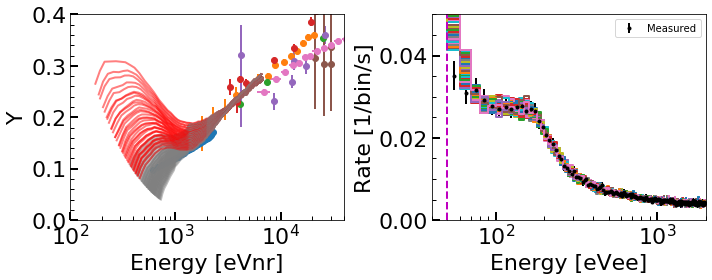

In [623]:
fig,axs=subplots(1,2,figsize=(10,4))
dosmear=True
seed=0
Fthis=0.1161

#Add other measurements from lit
import R68_plot_tools as pt
pt.plotOldYs(axs[0],fmt='o')

axs[1].errorbar(Ebin_ctr[Ebin_ctr>50],R_meas[Ebin_ctr>50],(dR_meas.T[Ebin_ctr>50]).T, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')

axs[0].set_prop_cycle(None)#Reset color cycle
axs[1].set_prop_cycle(None)

for E_nrs,Ys,fer,fnr,fng,good in zip(lE_nrs,lYs,lfer,lfnr,lfng,cgood):
    if not good:
        continue
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    
    if fng==0:
        color='red'
    else:
        color='gray'
    axs[0].plot(E_nrs[cFit],Ys[cFit],'-',color=color,alpha=0.5,zorder=3)#,color='gray')#,label='Sim')
    
    #Smear
    #Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[0],0,E_nrs[-1],Ys[-1])
    Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
    Y=Yield.Yield('User',[Y_fit])
    #axs[0].plot(E_nrs,Y.calc(E_nrs),':k',zorder=10)
    
    if dosmear:
        E_er_sm=spec.getSmeared(E_er,seed=seed,F=Fthis)
        E_er_sm[E_er_sm<0]=0
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed,F=Fthis)
        E_nr_eVee_sm[E_nr_eVee_sm<0]=0
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed,F=Fthis)
        E_ng_eVee_sm[E_ng_eVee_sm<0]=0
        #print('E_nr_eVee_sm[:5] = ',E_nr_eVee_sm[:5])
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

    #axs[1].step(Ebin_ctr,R_er,where='mid',label='ER')
    #axs[1].step(Ebin_ctr,R_nr,where='mid',label='NR')
    #axs[1].step(Ebin_ctr,R_ng,where='mid')#,label='(n,gamma)')

    step(Ebin_ctr,R_er+R_nr+R_ng,where='mid')#,label='Sim')#+' fng='+str(fng))



#axs[0].set_xlim(0,5e2)
#axs[0].set_xlim(3e2,2e4);
axs[0].set_xlim(1e2,4e4);
axs[0].set_xscale('log')
axs[0].set_ylim(0,0.4)
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
#axs[0].legend()

axs[1].axvline(50,linestyle='--',color='m')

axs[1].set_ylim(0,0.05)
axs[1].set_xlim(40,2e3)
axs[1].set_xscale('log')
#axs[1].set_xlim(0,250)
axs[1].set_xlabel('Energy [eVee]')
axs[1].set_ylabel('Rate [1/bin/s]')

axs[1].legend()

tight_layout()

fnr=(5.6,9.0)
fer=(1.3,4.2)
0.2731578947368421 0.28368421052631576


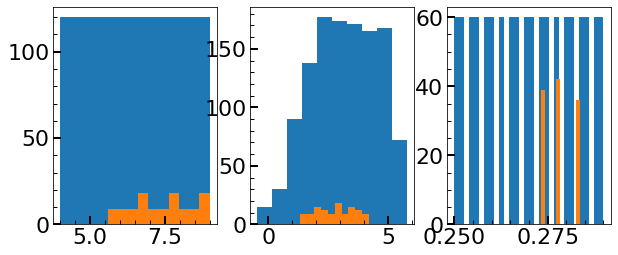

In [624]:
fig,axs=subplots(1,3,figsize=(10,4))

axs[0].hist(lfnr);
axs[0].hist(lfnr[cgood],bins=10);
print(f'fnr=({min(lfnr[cgood]):.1f},{max(lfnr[cgood]):.1f})')

axs[1].hist(lfer);
axs[1].hist(lfer[cgood],bins=10);
print(f'fer=({min(lfer[cgood]):.1f},{max(lfer[cgood]):.1f})')

axs[2].hist(lY_max,bins=30);
axs[2].hist(lY_max[cgood],bins=10);

print(min(lY_max[cgood]),max(lY_max[cgood]))

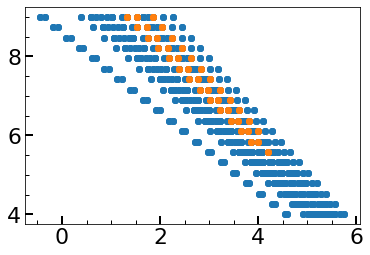

In [625]:
plot(lfer,lfnr,'o')
plot(lfer[cgood],lfnr[cgood],'o')

In [626]:
#Pick mins and maxes at a given energy
#This isn't quite right, since envelope is not jsut from a single curve

#ifng0_max=np.where(Y_4keV==np.max(Y_4keV[cgood&(lfng==0)]))[0][0]
#ifng0_min=np.where(Y_4keV==np.min(Y_4keV[cgood&(lfng==0)]))[0][0]
#ifng_max=np.where(Y_4keV==np.max(Y_4keV[cgood&(lfng!=0)]))[0][0]
#ifng_min=np.where(Y_4keV==np.min(Y_4keV[cgood&(lfng!=0)]))[0][0]

ifng0=np.argwhere(cgood&(lfng==0))
ifng0_min=ifng0[np.argmin(Y_1keV[ifng0])][0]
ifng0_max=ifng0[np.argmax(Y_1keV[ifng0])][0]

ifng=np.argwhere(cgood&(lfng!=0))
ifng_min=ifng[np.argmin(Y_1keV[ifng])][0]
ifng_max=ifng[np.argmax(Y_1keV[ifng])][0]

print(ifng0_min,ifng0_max,ifng_min,ifng_max)

1017 798 1018 800


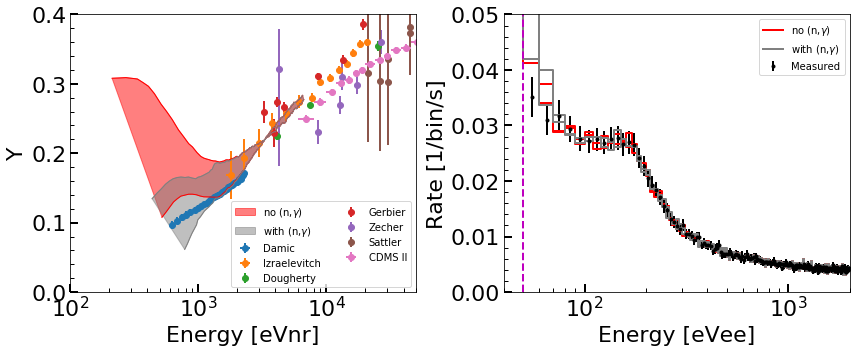

In [627]:
fig,axs=subplots(1,2,figsize=(12,5))
dosmear=True
seed=0
Fthis=0.1161

#Add other measurements from lit
import R68_plot_tools as pt
pt.plotOldYs(axs[0],fmt='o')

axs[1].errorbar(Ebin_ctr[Ebin_ctr>50],R_meas[Ebin_ctr>50],(dR_meas.T[Ebin_ctr>50]).T, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')

axs[0].set_prop_cycle(None)#Reset color cycle
axs[1].set_prop_cycle(None)

#labels=['fng=0','fng=2.037±0.408']
labels=[r'no (n,$\gamma$)',r'with (n,$\gamma$)']
colors=['red','gray']

for inds,label,color in zip([[ifng0_max,ifng0_min],[ifng_max,ifng_min]],labels,colors):
#for E_nrs,Ys,fer,fnr,fng,good in zip(lE_nrs,lYs,lfer,lfnr,lfng,cgood):

    i=inds[0]
    j=inds[1]
    
    cFit1=(Ebin_ctr>50) &(lE_nrs[i]>0) & (np.isfinite(lE_nrs[i])) & (np.insert(np.diff(lE_nrs[i])>0,-1,True))
    E_nrs1=lE_nrs[i][cFit1]
    Ys1=lYs[i][cFit1]
    Y_fCS1=CubicSpline(E_nrs1,Ys1,extrapolate=True)
    
    cFit2=(Ebin_ctr>50) &(lE_nrs[j]>0) & (np.isfinite(lE_nrs[j])) & (np.insert(np.diff(lE_nrs[j])>0,-1,True))
    E_nrs2=lE_nrs[j][cFit2]
    Ys2=lYs[j][cFit2]
    Y_fCS2=CubicSpline(E_nrs2,Ys2,extrapolate=True)
    
    line1=axs[0].plot(E_nrs1[2:],Ys1[2:],'-',color=color,linewidth=1,zorder=3)
    axs[0].plot(E_nrs2[2:],Ys2[2:],'-',linewidth=1,color=line1[0].get_color(),zorder=3)
    
    plt.sca(axs[0])
    fill(np.concatenate((E_nrs1[2:],E_nrs2[2:][::-1])),np.concatenate((Ys1[2:],Ys2[2:][::-1])),alpha=0.5,
         color=line1[0].get_color(),label=label)

    
    #Smear
    Y_fit1 = lambda E: Y_conditioned(E,Y_fCS1,E_nrs1[0],Ys1[0],E_nrs1[-1],Ys1[-1])
    Y1=Yield.Yield('User',[Y_fit1])
    Y_fit2 = lambda E: Y_conditioned(E,Y_fCS2,E_nrs2[0],Ys2[0],E_nrs2[-1],Ys2[-1])
    Y2=Yield.Yield('User',[Y_fit2])
    
    if dosmear:
        E_er_sm=spec.getSmeared(E_er,seed=seed,F=Fthis)
        E_er_sm[E_er_sm<0]=0
        
        E_nr_eVee_sm1=spec.getSmeared(NRtoER(E_nr,Y1,V,eps),seed=seed,F=Fthis)
        E_nr_eVee_sm1[E_nr_eVee_sm1<0]=0
        E_nr_eVee_sm2=spec.getSmeared(NRtoER(E_nr,Y2,V,eps),seed=seed,F=Fthis)
        E_nr_eVee_sm2[E_nr_eVee_sm2<0]=0
        
        E_ng_eVee_sm1=spec.getSmeared(NRtoER(E_ng,Y1,V,eps),seed=seed,F=Fthis)
        E_ng_eVee_sm1[E_ng_eVee_sm1<0]=0
        E_ng_eVee_sm2=spec.getSmeared(NRtoER(E_ng,Y2,V,eps),seed=seed,F=Fthis)
        E_ng_eVee_sm2[E_ng_eVee_sm2<0]=0
        #print('E_nr_eVee_sm[:5] = ',E_nr_eVee_sm[:5])
    else:
        E_er_sm=E_er
        E_nr_eVee_sm1=NRtoER(E_nr,Y1,V,eps)
        E_nr_eVee_sm2=NRtoER(E_nr,Y2,V,eps)
        E_ng_eVee_sm1=NRtoER(E_ng,Y1,V,eps)
        E_ng_eVee_sm2=NRtoER(E_ng,Y2,V,eps)
    
    C_er1,_=np.histogram(E_er_sm,bins=Ebins)
    R_er1=lfer[i]*C_er1/tlive_er
    C_er2,_=np.histogram(E_er_sm,bins=Ebins)
    R_er2=lfer[j]*C_er2/tlive_er
    
    C_nr1,_=np.histogram(E_nr_eVee_sm1,bins=Ebins)
    R_nr1=lfnr[i]*C_nr1/tlive_nr
    C_nr2,_=np.histogram(E_nr_eVee_sm2,bins=Ebins)
    R_nr2=lfnr[j]*C_nr2/tlive_nr
    
    C_ng1,_=np.histogram(E_ng_eVee_sm1,bins=Ebins)
    R_ng1=lfng[i]*C_ng1/tlive_ng
    C_ng2,_=np.histogram(E_ng_eVee_sm2,bins=Ebins)
    R_ng2=lfng[j]*C_ng2/tlive_ng

    #axs[1].step(Ebin_ctr,R_er,where='mid',label='ER')
    #axs[1].step(Ebin_ctr,R_nr,where='mid',label='NR')
    #axs[1].step(Ebin_ctr,R_ng1,'--',where='mid',color=color)#,label='(n,gamma)')
    #axs[1].step(Ebin_ctr,R_ng2,'--',where='mid',color=color)

    axs[1].step(Ebin_ctr,R_er1+R_nr1+R_ng1,color=color,where='mid',label=label)#+' fng='+str(fng))
    axs[1].step(Ebin_ctr,R_er2+R_nr2+R_ng2,color=color,where='mid')

    
#axs[1].axvline(NRtoER(izr['Enr'][0],(izr['Y']-izr['dY'])[0],V,eps))
#axs[1].axvline(NRtoER(izr['Enr'][0],(izr['Y']+izr['dY'])[0],V,eps))

#axs[0].set_xlim(0,5e2)
axs[0].set_xlim(1e2,5e4);
axs[0].set_xscale('log')
axs[0].set_ylim(0,0.4)
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
axs[0].legend(loc='lower right',ncol=2)

axs[1].axvline(50,linestyle='--',color='m')

axs[1].set_ylim(0,0.05)
axs[1].set_xlim(40,2e3)
axs[1].set_xscale('log')
#axs[1].set_xlim(0,250)
axs[1].set_xlabel('Energy [eVee]')
axs[1].set_ylabel('Rate [1/bin/s]')

axs[1].legend()

tight_layout()
#savefig('figures/intmeth_izr_benchmark_NGcompare.png')

In [628]:
#TODO: Automatic selection of Ebins to exclude lowest few bins based on spectra mismatch

In [629]:
#Find the full enevelope of yield curves
#Includes first and last point of each curve and the min and max Y at each Enr

def getEYenvelope(lE_nrs_sample,lYs_sample,eVeeMin=50):
    Yenv_left=[]
    Yenv_right=[]
    Enr_env_left=[]
    Enr_env_right=[]

    for E_nrs,Ys in zip(lE_nrs_sample,lYs_sample):
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Yenv_left.append(Ys[cFit&(Ebin_ctr>eVeeMin)][0])
        Enr_env_left.append(E_nrs[cFit&(Ebin_ctr>eVeeMin)][0])
        Yenv_right.append(Ys[cFit&(Ebin_ctr>eVeeMin)][-1])
        Enr_env_right.append(E_nrs[cFit&(Ebin_ctr>eVeeMin)][-1])
        
    Enr_env_right=np.array(Enr_env_right)
    Yenv_right=np.array(Yenv_right)
    Enr_env_left=np.array(Enr_env_left)
    Yenv_left=np.array(Yenv_left)

    Enr_env_top=np.linspace(Enr_env_left[np.argmax(Yenv_left)],Enr_env_right[np.argmax(Yenv_right)],1000)
    Ytestmax=[]
    for E_nrs,Ys in zip(lE_nrs_sample,lYs_sample):
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Y=getYfitCond(E_nrs,Ys)
        Ytesti=Y.calc(Enr_env_top)
        cgoodval=(Enr_env_top>=np.min(E_nrs[Ebin_ctr>eVeeMin]))
        Ytesti[~cgoodval]=-99
        Ytestmax.append(Ytesti)
    Yenv_top=np.max(np.array(Ytestmax),axis=0)        

    Enr_env_bottom=np.linspace(Enr_env_left[np.argmin(Yenv_left)],Enr_env_right[np.argmin(Yenv_right)],1000)
    Ytestmin=[]
    for E_nrs,Ys in zip(lE_nrs_sample,lYs_sample):
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Y=getYfitCond(E_nrs,Ys)
        Ytesti=Y.calc(Enr_env_bottom)
        cgoodval=(Enr_env_bottom>=np.min(E_nrs[Ebin_ctr>eVeeMin]))
        Ytesti[~cgoodval]=99
        Ytestmin.append(Ytesti)
    Yenv_bottom=np.min(np.array(Ytestmin),axis=0)        

    #Need to sort the points so that they form a closed polygon
    #Go clockwise from top left

    Enr_env=np.concatenate( (Enr_env_top, Enr_env_right[np.argsort(Enr_env_right)], Enr_env_bottom[::-1], Enr_env_left[np.argsort(Enr_env_left)][::-1]) )
    Yenv=np.concatenate((Yenv_top, Yenv_right[np.argsort(Enr_env_right)], Yenv_bottom[::-1], Yenv_left[np.argsort(Enr_env_left)][::-1]))

    return (Enr_env, Yenv)

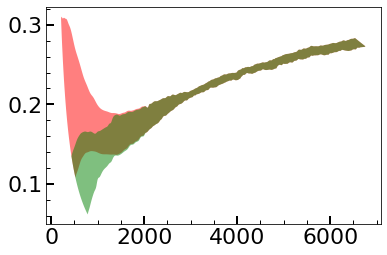

In [630]:
#plot(Enr_env_top,Yenv_top,'.')
#plot(Enr_env_bottom,Yenv_bottom,'.')
#plot(Enr_env_right,Yenv_right,'.')
#plot(Enr_env_left,Yenv_left,'.')

#fill(*getEYenvelope(lE_nrs[cgood],lYs[cgood]),'gray',alpha=0.5)
fill(*getEYenvelope(lE_nrs[cgood&(lfng==0)],lYs[cgood&(lfng==0)],eVeeMin=70),'r',alpha=0.5)
fill(*getEYenvelope(lE_nrs[cgood&(lfng!=0)],lYs[cgood&(lfng!=0)],eVeeMin=70),'g',alpha=0.5)

In [650]:
#Find the full range of rates for each component for plotting
def getERminmax(lE_nrs_sample,lYs_sample,lfer_sample,lfnr_sample,lfng_sample,dosmear=True,FanoER=0.1161,FanoNR=0.1161):
    R_er_test=[]
    R_nr_test=[]
    R_ng_test=[]
    
    for E_nrs,Ys,fer,fnr,fng in zip(lE_nrs_sample,lYs_sample,lfer_sample,lfnr_sample,lfng_sample):
        Y=getYfitCond(E_nrs,Ys)
        
        if dosmear:
            E_er_sm=spec.getSmeared(E_er,seed=seed,F=FanoER)
            #E_er_sm[E_er_sm<0]=0
            E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed,F=FanoNR)
            #E_nr_eVee_sm[E_nr_eVee_sm<0]=0
            E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed,F=FanoNR)
            #E_ng_eVee_sm[E_ng_eVee_sm<0]=0
        else:
            E_er_sm=E_er
            E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
            E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)


        C_er,_=np.histogram(E_er_sm,bins=Ebins)
        R_er=fer*C_er/tlive_er

        C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
        R_nr=fnr*C_nr/tlive_nr

        C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
        R_ng=fng*C_ng/tlive_ng

        R_er_test.append(R_er)
        R_nr_test.append(R_nr)
        R_ng_test.append(R_ng)
    
    R_er_test=np.array(R_er_test)
    R_nr_test=np.array(R_nr_test)
    R_ng_test=np.array(R_ng_test)
    
    R_total_test=R_er_test+R_nr_test+R_ng_test

    Renvelopes={'eVee':Ebin_ctr,
                'ER':{'max':np.max(R_er_test,axis=0),'min':np.min(R_er_test,axis=0)},
                'NR':{'max':np.max(R_nr_test,axis=0),'min':np.min(R_nr_test,axis=0)},
                'NG':{'max':np.max(R_ng_test,axis=0),'min':np.min(R_ng_test,axis=0)},
                'Total':{'max':np.max(R_total_test,axis=0),'min':np.min(R_total_test,axis=0)},
               }
    return Renvelopes

In [651]:
cut=cgood&(lfng!=0)
ERenvData=getERminmax(lE_nrs[cut],lYs[cut],lfer[cut],lfnr[cut],lfng[cut])

(0, 0.04)

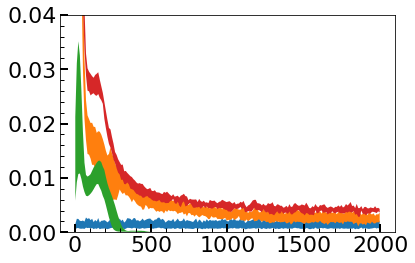

In [652]:
fill_between(ERenvData['eVee'],ERenvData['ER']['min'],ERenvData['ER']['max'])
fill_between(ERenvData['eVee'],ERenvData['NR']['min'],ERenvData['NR']['max'])
fill_between(ERenvData['eVee'],ERenvData['NG']['min'],ERenvData['NG']['max'])
fill_between(ERenvData['eVee'],ERenvData['Total']['min'],ERenvData['Total']['max'])

ylim(0,0.04)

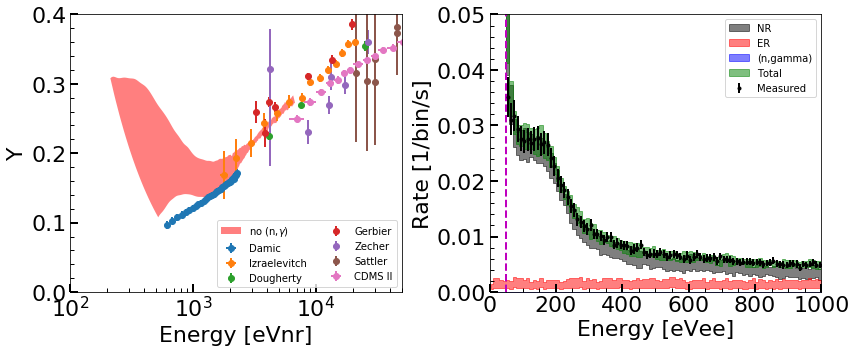

In [653]:
fig,axs=subplots(1,2,figsize=(12,5))

cut=cgood&(lfng!=0)
cut=cgood&(lfng==0)

#Add other measurements from lit
import R68_plot_tools as pt
pt.plotOldYs(axs[0],fmt='o')
axs[0].fill(*getEYenvelope(lE_nrs[cut],lYs[cut],eVeeMin=70),'r',alpha=0.5,label=labels[0])
#axs[0].fill(*getEYenvelope(lE_nrs[cut],lYs[cut],eVeeMin=70),'g',alpha=0.5,label=labels[1])

axs[1].errorbar(Ebin_ctr[Ebin_ctr>50],R_meas[Ebin_ctr>50],(dR_meas.T[Ebin_ctr>50]).T, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')

axs[0].set_prop_cycle(None)#Reset color cycle
axs[1].set_prop_cycle(None)

#labels=['fng=0','fng=2.037±0.408']
labels=[r'no (n,$\gamma$)',r'with (n,$\gamma$)']
colors=['red','gray']


ERenvData=getERminmax(lE_nrs[cut],lYs[cut],lfer[cut],lfnr[cut],lfng[cut])

axs[1].fill_between(ERenvData['eVee'],ERenvData['NR']['min'],ERenvData['NR']['max'],color='k',alpha=0.5,step='mid',label='NR')
axs[1].fill_between(ERenvData['eVee'],ERenvData['ER']['min'],ERenvData['ER']['max'],color='r',alpha=0.5,step='mid',label='ER')
axs[1].fill_between(ERenvData['eVee'],ERenvData['NG']['min'],ERenvData['NG']['max'],color='b',alpha=0.5,step='mid',label='(n,gamma)')

axs[1].fill_between(ERenvData['eVee'],ERenvData['Total']['min'],ERenvData['Total']['max'],color='g',alpha=0.5,step='mid',label='Total')
    

#axs[0].set_xlim(0,5e2)
axs[0].set_xlim(1e2,5e4);
axs[0].set_xscale('log')
axs[0].set_ylim(0,0.4)
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
axs[0].legend(loc='lower right',ncol=2)

axs[1].axvline(50,linestyle='--',color='m')

axs[1].set_ylim(0,0.05)
axs[1].set_xlim(0,1e3)
#axs[1].set_xscale('log')
#axs[1].set_xlim(0,250)
axs[1].set_xlabel('Energy [eVee]')
axs[1].set_ylabel('Rate [1/bin/s]')

axs[1].legend()

tight_layout()
#savefig('figures/intmeth_izr_benchmark_noNG_components.png')
#savefig('figures/intmeth_izr_benchmark_wNG_components.png')

# Include variations in Fano
Let's again scan over a range of values, but also include Fano smearing and variations in NR Fano.

We'll also introduce a dictionary structure to hold all these arrays of data from each curve

In [641]:
def extract_Y_v3(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, Ebins=None, verbose=True):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global tlive_er,tlive_nr,tlive_ng, V, eps
    
    if Ebins is None:
        Ebins=np.linspace(0,2e3,201)
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    
    R_meas,dR_meas=spec.doBkgSub(meas, Ebins, Efit_min=50,Efit_max=2e3,
                                 doEffsyst=False, doBurstLeaksyst=False,
                                 output='reco-rate')
    
    E_er_max=Ebins[-1]
    E_nr_max=ERtoNR(E_er_max,Y_max,V,eps)

    Ebin_ctr_rev=Ebin_ctr[::-1]

    rev_csum_meas=np.cumsum(R_meas[::-1])

    R_sim_er=fer*np.histogram(E_er,Ebins)[0]/tlive_er
    rev_csum_er=np.cumsum(R_sim_er[::-1])

    w_nr=fnr/tlive_nr*np.ones(np.sum(E_nr<=E_nr_max))
    w_ng=fng/tlive_ng*np.ones(np.sum(E_ng<=E_nr_max))
    if verbose:
        print(f'{np.max(rev_csum_meas[np.isfinite(rev_csum_meas)])},{np.max(rev_csum_er)},{np.sum(w_nr)},{np.sum(w_ng)}')
        
    E_nrng=np.concatenate((E_nr[E_nr<=E_nr_max],E_ng[E_ng<=E_nr_max]))
    w_nrng=np.concatenate((w_nr,w_ng))

    E_nrng_rev_srt=(E_nrng[np.argsort(E_nrng)])[::-1]
    w_nrng_rev_srt=(w_nrng[np.argsort(E_nrng)])[::-1]
    rev_csum_nrng=np.cumsum(w_nrng_rev_srt)

    diff=rev_csum_meas-rev_csum_er
    E_nrs=[]
    error=[]
    for entry in diff:
        if np.isfinite(entry):
            args=np.argwhere(rev_csum_nrng>=entry)
            if len(args)==0:
                E_nrs.append(-99)
            else:
                E_nr_this=E_nrng_rev_srt[args[0][0]]
                error.append(rev_csum_nrng[args[0][0]]-entry)
                if len(E_nrs)>0:
                    E_nrs.append(min(E_nr_this,E_nrs[-1]))
                else:
                    E_nrs.append(E_nr_this)
        else:
            E_nrs.append(-999)
            error.append(-999)
    E_nrs=np.array(E_nrs[::-1])
    Ys=((Ebins[:-1]/E_nrs)*(1+V/eps)-1)*eps/V
    error=np.array(error)
    
    return (E_nrs,Ys,error)

#Extract yield curve using the integral method
#Treats each event as a single scatter of the total energy
#fer: ER livetime factor
#fnr: NR livetime factor
#fng: NG livetime factor
#Y_max: Yield value that corresponds to the highest bin edge of Ebins

#v3: Separate ER and NR Fanos. Also allow smeared energies to be negative

tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']
from scipy.interpolate import CubicSpline

def extract_Y_wSmear_v3(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, nIt=2, FanoER=0.1161, FanoNR=0.1161, Ebins=None, seed=None, verbose=True):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global tlive_er,tlive_nr,tlive_ng, V, eps
    
    if Ebins is None:
        Ebins=np.linspace(0,2e3,201)
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    
    #Initial yield, with no resolution effects
    E_nrs,Ys,errors=extract_Y_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, Ebins, verbose)
    
    iIt=0
    while iIt<nIt:
        iIt+=1
        
        if verbose:
            print('Smearing ',iIt)
        
        Y=getYfitCond(E_nrs,Ys)

        E_nr_eVee=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee=NRtoER(E_ng,Y,V,eps)

        ERtoNR_fit=getEEtoNRfitCond(E_nrs,Y)
        
        E_er_sm=spec.getSmeared(E_er,seed=seed,F=FanoER)
        E_nr_sm=ERtoNR_fit(spec.getSmeared(E_nr_eVee,seed=seed,F=FanoNR))
        E_ng_sm=ERtoNR_fit(spec.getSmeared(E_ng_eVee,seed=seed,F=FanoNR))
        
        if verbose:
            print('E_nr_sm[:5] = ',E_nr_sm[:5])
        E_nrs,Ys,errors=extract_Y_v3(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, Ebins, verbose)
        
    return (E_nrs,Ys,errors)

def Y_conditioned(E, Y_fCS, Emin, Ymin, Emax, Ymax):
    y=Y_fCS(E)
    y[E>=Emax]=Ymax
    y[E<=Emin]=Ymin
    return y

def getYfitCond(E_nrs,Ys):
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
    return Yield.Yield('User',[Y_fit])

#Fitted function to map from eVee back to eVnr
#But need to condition it outside of the spline region.
#Just extrapolate with linear from each end
def getEEtoNRfitCond(E_nrs,Y):
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    
    xx=NRtoER(E_nrs[cFit],Y,V,eps)
    yy=E_nrs[cFit]
    
    ERtoNR_fCS=CubicSpline(xx,yy,extrapolate=True)
    pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))#Should maintain const Y at low end
    pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
    EEtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fCS(E) + (E>xx[-1])*pf_hi(E)

    return EEtoNR_fcombo

In [ ]:
#Single data structure to hold all those arrays of stuff

scanData={'lY_max':[], 'lfer':[], 'lfnr':[], 'lfng':[],
          'lE_nrs':[], 'lYs':[], 'lerrors':[], 'lFanoER':[],'lFanoNR':[]}

for Y_max in tqdm(np.linspace(0.25,0.29,20)):
    for fnr in np.linspace(4,9,20):
        for fng in [0,2.037+0.408,2.037,2.037-0.408]:
            for FanoNR in [0.1161,1,2,5]:
    
                scanData['lY_max'].append(Y_max)

                #Normalize near 2keV
                R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
                R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
                R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

                fer=(R0_meas-fnr*R0_nr)/R0_er

                scanData['lfer'].append(fer)
                scanData['lfnr'].append(fnr)
                scanData['lfng'].append(fng)

                scanData['lFanoER'].append(0.1161)
                scanData['lFanoNR'].append(FanoNR)

                E_nrs,Ys,errors=extract_Y_wSmear_v3(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                                                    nIt=1, Ebins=np.linspace(0,2e3,201), seed=0,
                                                    FanoER=0.1161, FanoNR=FanoNR, verbose=False)

                scanData['lE_nrs'].append(E_nrs)
                scanData['lYs'].append(Ys)
                scanData['lerrors'].append(errors)


for key in scanData.keys():
    scanData[key]=np.array(scanData[key])
    
scanData['N']=len(scanData['lY_max'])

In [688]:
#Save results
import pickle

if False:
    with open( "data/intmeth_scan_v3.p", "wb" ) as file:
        pickle.dump( scanData, file )
else:
    with open( "data/intmeth_scan_v3.p", "rb" ) as file:
        scanData = pickle.load( file )

In [791]:
#Find those which are consistent with Izr
scanData['cgood']=[]
scanData['IzrChi']=[]

for i in zip(range(scanData['N'])):
    Y=getYfitCond(scanData['lE_nrs'][i],scanData['lYs'][i])
    cizr=izr['Enr']<scanData['lE_nrs'][i][-1]

    scanData['IzrChi'].append(np.sum((((Y.calc(izr['Enr'])-izr['Y'])/izr['dY'])[cizr])**2))
    scanData['cgood'].append(((np.abs(Y.calc(izr['Enr'])-izr['Y'])<1*izr['dY'])[cizr]).all())
    
scanData['cgood']=np.array(scanData['cgood'])
scanData['IzrChi']=np.array(scanData['IzrChi'])
print(np.sum(scanData['cgood']),'/',scanData['N'])

576 / 6400


In [853]:
#Find the full range of rates for each component for plotting
def getERminmax_v3(scanData,cut,dosmear=True,seed=None,nAvg=1):
    R_er_test=[]
    R_nr_test=[]
    R_ng_test=[]
    
    for i in range(len(scanData['lE_nrs'][cut])):
        E_nrs=scanData['lE_nrs'][cut][i]
        Ys=scanData['lYs'][cut][i]
        fer=scanData['lfer'][cut][i]
        fnr=scanData['lfnr'][cut][i]
        fng=scanData['lfng'][cut][i]
        FanoER=scanData['lFanoER'][cut][i]
        FanoNR=scanData['lFanoNR'][cut][i]
        
        Y=getYfitCond(E_nrs,Ys)
        
        
        R_er_avg=[]
        R_nr_avg=[]
        R_ng_avg=[]
        for iteration in range(nAvg):
            if dosmear:
                E_er_sm=spec.getSmeared(E_er,seed=seed,F=FanoER)
                E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed,F=FanoNR)
                E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed,F=FanoNR)
            else:
                E_er_sm=E_er
                E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
                E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)


            C_er,_=np.histogram(E_er_sm,bins=Ebins)
            R_er=fer*C_er/tlive_er

            C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
            R_nr=fnr*C_nr/tlive_nr

            C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
            R_ng=fng*C_ng/tlive_ng
            
            R_er_avg.append(R_er)
            R_nr_avg.append(R_nr)
            R_ng_avg.append(R_ng)

        R_er_test.append(np.mean(np.array(R_er_avg),axis=0))
        R_nr_test.append(np.mean(np.array(R_nr_avg),axis=0))
        R_ng_test.append(np.mean(np.array(R_ng_avg),axis=0))
    
    R_er_test=np.array(R_er_test)
    R_nr_test=np.array(R_nr_test)
    R_ng_test=np.array(R_ng_test)
    
    R_total_test=R_er_test+R_nr_test+R_ng_test

    Renvelopes={'eVee':Ebin_ctr,
                'ER':{'max':np.max(R_er_test,axis=0),'min':np.min(R_er_test,axis=0)},
                'NR':{'max':np.max(R_nr_test,axis=0),'min':np.min(R_nr_test,axis=0)},
                'NG':{'max':np.max(R_ng_test,axis=0),'min':np.min(R_ng_test,axis=0)},
                'Total':{'max':np.max(R_total_test,axis=0),'min':np.min(R_total_test,axis=0)},
               }
    return Renvelopes

In [690]:
#Print the range of vals at xy on ax with label
def printValueRange(ax,x,y,label,vals,size=14,fformat='.1f'):
    if np.min(vals)==np.max(vals):
        ax.text(x,y,label+f'{np.min(vals):{fformat}}',size=size)
    else:
        ax.text(x,y,label+f'{np.min(vals):{fformat}}-{np.max(vals):{fformat}}',size=size)

39


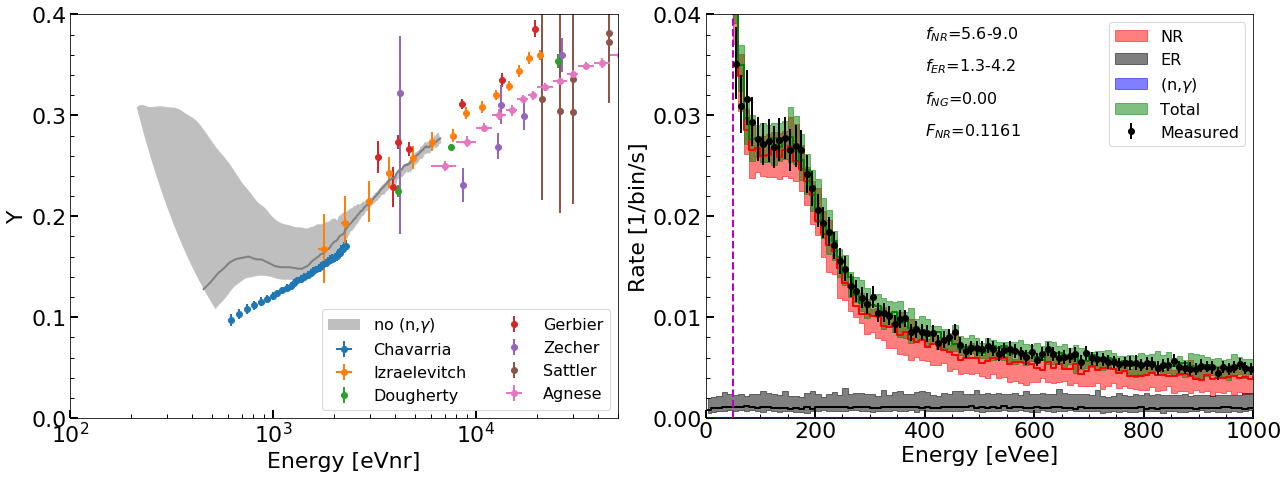

In [902]:
fig_w=9
fig,axs=subplots(1,2,figsize=(2*fig_w, fig_w*(.75)))

iPlot=0

if iPlot==0:
    cut=scanData['cgood']&(scanData['lfng']==0)&(scanData['lFanoNR']==0.1161)
else:
    cut=scanData['cgood']&(scanData['lfng']!=0)&(scanData['lFanoNR']==0.1161)

#Best fit to Izr
iBest=np.argwhere(cut)[:,0][np.argmin(scanData['IzrChi'][cut])]

labels=[r'no (n,$\gamma$)',r'with (n,$\gamma$)']
colors=['gray','green']

print(np.sum(cut))

#Print some info
printValueRange(axs[1],4e2,4/5*0.047,r'$f_{NR}$=',scanData['lfnr'][cut],size=16)
printValueRange(axs[1],4e2,4/5*0.043,r'$f_{ER}$=',scanData['lfer'][cut],size=16)
printValueRange(axs[1],4e2,4/5*0.039,r'$f_{NG}$=',scanData['lfng'][cut],size=16,fformat='.2f')
printValueRange(axs[1],4e2,4/5*0.035,r'$F_{NR}$=',scanData['lFanoNR'][cut],size=16,fformat='')


#Add other measurements from lit
import R68_plot_tools as pt
pt.plotOldYs(axs[0],fmt='o',markersize=6)
#axs[0].fill(*getEYenvelope(scanData['lE_nrs'][cut],scanData['lYs'][cut],eVeeMin=70),'r',alpha=0.5,label=labels[0])
#axs[0].fill(*getEYenvelope(scanData['lE_nrs'][cut],scanData['lYs'][cut],eVeeMin=70),'g',alpha=0.5,label=labels[1])
axs[0].fill(*getEYenvelope(scanData['lE_nrs'][cut],scanData['lYs'][cut],eVeeMin=70),
            colors[iPlot],alpha=0.5,label=labels[iPlot])


axs[0].plot(scanData['lE_nrs'][iBest][Ebin_ctr>70],scanData['lYs'][iBest][Ebin_ctr>70], colors[iPlot])

axs[1].errorbar(Ebin_ctr[Ebin_ctr>50],R_meas[Ebin_ctr>50],(dR_meas.T[Ebin_ctr>50]).T,
                ecolor='k', marker='o',markersize=6,color='k', linestyle='none',label='Measured',zorder=5)

axs[0].set_prop_cycle(None)#Reset color cycle
axs[1].set_prop_cycle(None)


ERenvData=getERminmax_v3(scanData,cut,nAvg=1)
ERmidData=getERminmax_v3(scanData,np.arange(len(scanData['lE_nrs']))==iBest,nAvg=5)#Cheat to get mid. min==max

axs[1].step(ERmidData['eVee'],ERmidData['NR']['min'],color='r',where='mid')
axs[1].step(ERmidData['eVee'],ERmidData['ER']['min'],color='k',where='mid')
axs[1].step(ERmidData['eVee'],ERmidData['NG']['min'],color='b',where='mid')
axs[1].step(ERmidData['eVee'],ERmidData['Total']['min'],color='g',where='mid')

axs[1].fill_between(ERenvData['eVee'],ERenvData['NR']['min'],ERenvData['NR']['max'],color='r',alpha=0.5,step='mid',label='NR')
axs[1].fill_between(ERenvData['eVee'],ERenvData['ER']['min'],ERenvData['ER']['max'],color='k',alpha=0.5,step='mid',label='ER')
axs[1].fill_between(ERenvData['eVee'],ERenvData['NG']['min'],ERenvData['NG']['max'],color='b',alpha=0.5,step='mid',label=r'(n,$\gamma)$')
axs[1].fill_between(ERenvData['eVee'],ERenvData['Total']['min'],ERenvData['Total']['max'],color='g',alpha=0.5,step='mid',label='Total')

#Package for the standardized spectra plotter
#N_nr_plot=np.array([ERmidData['NR']['min'],ERenvData['NR']['max'],ERenvData['NR']['min']])
#N_er_plot=np.array([ERmidData['ER']['min'],ERenvData['ER']['max'],ERenvData['ER']['min']])
#N_ng_plot=np.array([ERmidData['NG']['min'],ERenvData['NG']['max'],ERenvData['NG']['min']])
#N_tot_plot=np.array([ERmidData['Total']['min'],ERenvData['Total']['max'],ERenvData['Total']['min']])


#spec.plotSpectra(axis=axs[1], E_bins=Ebins, N_nr=N_nr_plot, N_er=N_er_plot,
#                 N_ng=N_ng_plot, N_tot=N_tot_plot,
#                 N_meas=R_meas, dN_meas=dR_meas,
#                 xrange=(0,1e3), yrange=(0,0.04), thresh=50,
#                 wResidual=False, grid=False, yrange_res=(-100,100))

#axs[0].set_xlim(0,5e2)
axs[0].set_xlim(1e2,5e4);
axs[0].set_xscale('log')
axs[0].set_ylim(0,0.4)
axs[0].yaxis.set_major_locator(plt.MultipleLocator(0.1))
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
axs[0].legend(loc='lower right',ncol=2,prop={'size': 16})

axs[1].axvline(50,linestyle='--',color='m')

axs[1].set_ylim(0,0.04)
axs[1].yaxis.set_major_locator(plt.MultipleLocator(0.01))
axs[1].set_xlim(0,1e3)
#axs[1].set_xscale('log')
#axs[1].set_xlim(0,250)
axs[1].set_xlabel('Energy [eVee]')
axs[1].set_ylabel('Rate [1/bin/s]')

axs[1].legend(loc='upper right', prop={'size': 16})

tight_layout()

if iPlot==0:
    savefig('figures/intmeth_izr_benchmark_noNG_FNRFER.png')
elif iPlot==1:
    savefig('figures/intmeth_izr_benchmark_wNG_FNRFER.png')

# Better stability
Playing around with some earlier portions of this notebook has convinced me that we can stabilize the smearing iterations a bit better if we use linear interpolation instead of cubic and if we use linear (not flat) extrapolation of yield to low values. The cubic interpolation was sometimes doing crazy things between points. The extrapolation should help the low energy bins match better. I think the issue is that we need to pull the sub-threshold yield down lower, but we can only guess blindly at how it should be.

For speed, we can also remove the R_meas calculation and just use the global one.

We also added dynamic smearing, so it will iterate only until the spectra mostly agrees with measurement (with special emphasis on low energy bins) or until some max iteration is met.

In [1281]:
#v4: Remove R_meas calculation and use global value.
#Assumes R_meas matches Ebins.
def extract_Y_v4(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, Ebins=None, verbose=True):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global tlive_er,tlive_nr,tlive_ng, V, eps, R_meas
    
    if Ebins is None:
        Ebins=np.linspace(0,2e3,201)
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    
    #R_meas,dR_meas=spec.doBkgSub(meas, Ebins, Efit_min=50,Efit_max=2e3,
    #                             doEffsyst=False, doBurstLeaksyst=False,
    #                             output='reco-rate')
    
    E_er_max=Ebins[-1]
    E_nr_max=ERtoNR(E_er_max,Y_max,V,eps)

    Ebin_ctr_rev=Ebin_ctr[::-1]

    rev_csum_meas=np.cumsum(R_meas[::-1])

    R_sim_er=fer*np.histogram(E_er,Ebins)[0]/tlive_er
    rev_csum_er=np.cumsum(R_sim_er[::-1])

    w_nr=fnr/tlive_nr*np.ones(np.sum(E_nr<=E_nr_max))
    w_ng=fng/tlive_ng*np.ones(np.sum(E_ng<=E_nr_max))
    if verbose:
        print(f'{np.max(rev_csum_meas[np.isfinite(rev_csum_meas)])},{np.max(rev_csum_er)},{np.sum(w_nr)},{np.sum(w_ng)}')
        
    E_nrng=np.concatenate((E_nr[E_nr<=E_nr_max],E_ng[E_ng<=E_nr_max]))
    w_nrng=np.concatenate((w_nr,w_ng))

    E_nrng_rev_srt=(E_nrng[np.argsort(E_nrng)])[::-1]
    w_nrng_rev_srt=(w_nrng[np.argsort(E_nrng)])[::-1]
    rev_csum_nrng=np.cumsum(w_nrng_rev_srt)

    diff=rev_csum_meas-rev_csum_er
    E_nrs=[]
    error=[]
    for entry in diff:
        if np.isfinite(entry):
            args=np.argwhere(rev_csum_nrng>=entry)
            if len(args)==0:
                E_nrs.append(-99)
            else:
                E_nr_this=E_nrng_rev_srt[args[0][0]]
                error.append(rev_csum_nrng[args[0][0]]-entry)
                if len(E_nrs)>0:
                    E_nrs.append(min(E_nr_this,E_nrs[-1]))
                else:
                    E_nrs.append(E_nr_this)
        else:
            E_nrs.append(-999)
            error.append(-999)
    E_nrs=np.array(E_nrs[::-1])
    Ys=((Ebins[:-1]/E_nrs)*(1+V/eps)-1)*eps/V
    error=np.array(error)
    
    return (E_nrs,Ys,error)

#Extract yield curve using the integral method
#Treats each event as a single scatter of the total energy
#fer: ER livetime factor
#fnr: NR livetime factor
#fng: NG livetime factor
#Y_max: Yield value that corresponds to the highest bin edge of Ebins

#v3: Separate ER and NR Fanos. Also allow smeared energies to be negative
#v4: Add dynamic smearing iteration. Stop if smeared matches measured via some measure of closeness.
tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']
from scipy.interpolate import CubicSpline

def extract_Y_wSmear_v4(E_er, E_nr, E_ng, fer, fnr, fng, Y_max,
                        nItMax=2, fit_frac_all_goal=0.8, fit_frac_low_goal=1,
                        FanoER=0.1161, FanoNR=0.1161, Ebins=None, seed=None, verbose=True):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global tlive_er,tlive_nr,tlive_ng, V, eps
    
    if Ebins is None:
        Ebins=np.linspace(0,2e3,201)
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    
    #Initial yield, with no resolution effects
    E_nrs,Ys,errors=extract_Y_v4(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, Ebins, verbose)
    
    iIt=0
    while iIt<nItMax:
        
        if verbose:
            print('Smearing ',iIt)
        
        Y=getYfitCond_v4(E_nrs,Ys)

        E_nr_eVee=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee=NRtoER(E_ng,Y,V,eps)

        ERtoNR_fit=getEEtoNRfitCond_v4(E_nrs,Y)
        
        E_er_sm=spec.getSmeared(E_er,seed=seed,F=FanoER)
        E_nr_eVee_sm=spec.getSmeared(E_nr_eVee,seed=seed,F=FanoNR)
        E_ng_eVee_sm=spec.getSmeared(E_ng_eVee,seed=seed,F=FanoNR)

        #Check if the currently smeared version agrees with the measurement
        C_er,_=np.histogram(E_er_sm,bins=Ebins)
        R_er=fer*C_er/tlive_er

        C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
        R_nr=fnr*C_nr/tlive_nr

        C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
        R_ng=fng*C_ng/tlive_ng

        R_tot=R_er+R_nr+R_ng
        
        #Some goodness of fit condition
        #Hard to get this right because we want the whole thing to fit well, but are 
        #  especially concerned about the lowest few bins which tend to go astray
        R_max=R_meas[Ebin_ctr>50]+1*dR_meas[0][Ebin_ctr>50]
        R_min=R_meas[Ebin_ctr>50]-1*dR_meas[1][Ebin_ctr>50]
        #fracion of bins within error bars
        fit_frac_all=np.sum((R_tot[Ebin_ctr>50]<=R_max)&(R_tot[Ebin_ctr>50]>=R_min))/np.sum(Ebin_ctr>50)
        #Fraction of lowest 10 bins within error bars
        fit_frac_low=np.sum((R_tot[Ebin_ctr>50][:10]<=R_max[:10])&(R_tot[Ebin_ctr>50][:10]>=R_min[:10]))/10
        if verbose:
            print(fit_frac_all,fit_frac_low)
        
        if (fit_frac_all>=fit_frac_all_goal) and (fit_frac_low>=fit_frac_low_goal):
            break
            
        #Continue to the next iteration
        iIt+=1
        E_nr_sm=ERtoNR_fit(E_nr_eVee_sm)
        E_ng_sm=ERtoNR_fit(E_ng_eVee_sm)
        
        if verbose:
            print('E_nr_sm[:5] = ',E_nr_sm[:5])
        E_nrs,Ys,errors=extract_Y_v4(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, Ebins, verbose)
        
    return (E_nrs,Ys,errors,iIt)

def Y_conditioned_v4(E, Y_fit_func, E_nrs_fit, Ys_fit):
    y=Y_fit_func(E)
    
    ylow=np.poly1d(np.polyfit(E_nrs_fit[:2],Ys_fit[:2], 1))
    y[E<=E_nrs_fit[0]]=ylow(E[E<=E_nrs_fit[0]])
    
    yhi=np.poly1d(np.polyfit(E_nrs_fit[-2:],Ys_fit[-2:], 1))
    y[E>=E_nrs_fit[-1]]=yhi(E[E>=E_nrs_fit[-1]])

    y[y<0]=0
    return y

def getYfitCond_v4(E_nrs,Ys):
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fit_func=lambda E: np.interp(E,E_nrs[cFit],Ys[cFit])
    Y_fit = lambda E: Y_conditioned_v4(E,Y_fit_func,E_nrs[cFit],Ys[cFit])
    return Yield.Yield('User',[Y_fit])

#Fitted function to map from eVee back to eVnr
#But need to condition it outside of the spline region.
#Just extrapolate with linear from each end
def getEEtoNRfitCond_v4(E_nrs,Y):
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    
    xx=NRtoER(E_nrs[cFit],Y,V,eps)
    yy=E_nrs[cFit]
    
    ERtoNR_fit_func=lambda E: np.interp(E,xx,yy)
    pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))#Should maintain const Y at low end
    pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
    EEtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fit_func(E) + (E>xx[-1])*pf_hi(E)

    return EEtoNR_fcombo

# Smearing Iterations Test

In [1261]:
#Single data structure to hold all those arrays of stuff

scanData={'lY_max':[], 'lfer':[], 'lfnr':[], 'lfng':[],
          'lE_nrs':[], 'lYs':[], 'lerrors':[], 'lFanoER':[],'lFanoNR':[],
          'lnItMax':[],'liIt':[]}
Y_max=0.25
FanoNR=0#0.1161
fnr=4
fng=4#2.037+0.41

for nIt in tqdm([0,1,2,5,10,15,20,30]):
    scanData['lnItMax'].append(nIt)
    scanData['lY_max'].append(Y_max)

    #Normalize near 2keV
    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

    fer=(R0_meas-fnr*R0_nr)/R0_er


    scanData['lfer'].append(fer)
    scanData['lfnr'].append(fnr)
    scanData['lfng'].append(fng)

    scanData['lFanoER'].append(0.1161)
    scanData['lFanoNR'].append(FanoNR)

    E_nrs,Ys,errors,iIt=extract_Y_wSmear_v4(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                                            nItMax=nIt, fit_frac_all_goal=0.83, Ebins=np.linspace(0,2e3,201),
                                            seed=0,FanoER=0.1161, FanoNR=FanoNR, verbose=False)
    scanData['liIt'].append(iIt)
    scanData['lE_nrs'].append(E_nrs)
    scanData['lYs'].append(Ys)
    scanData['lerrors'].append(errors)


for key in scanData.keys():
    scanData[key]=np.array(scanData[key])
    
scanData['N']=len(scanData['lY_max'])

0.8256410256410256
1.0
0
0.8358974358974359
1.0
1
0.8358974358974359
1.0
1
0.8358974358974359
1.0
1
0.8358974358974359
1.0
1
0.8358974358974359
1.0
1
0.8358974358974359
1.0
1
0.8358974358974359
1.0
1


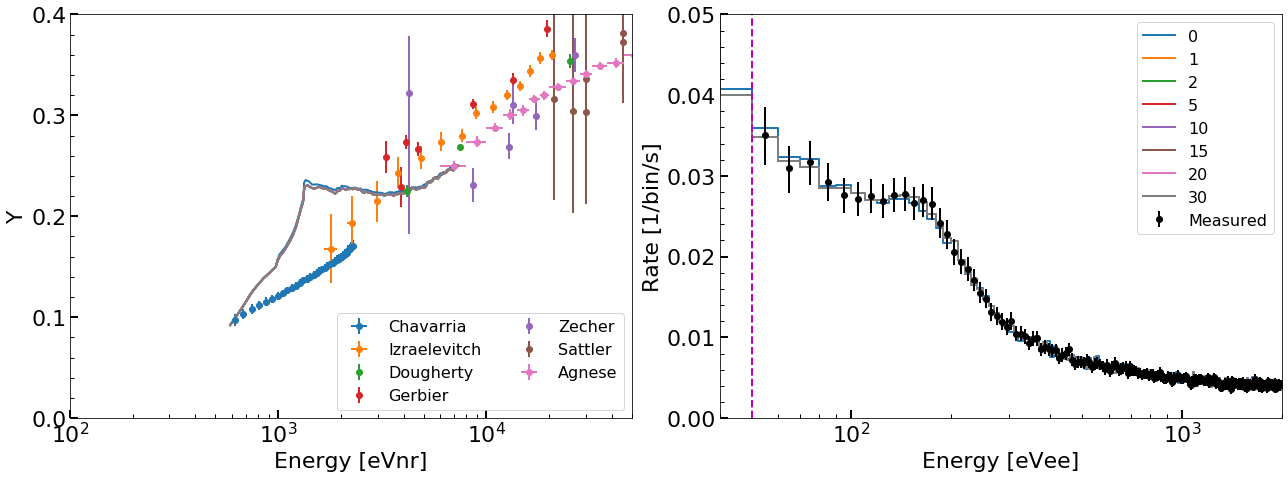

In [1262]:
fig_w=9
fig,axs=subplots(1,2,figsize=(2*fig_w, fig_w*(.75)))
seed=0

#Add other measurements from lit
import R68_plot_tools as pt
pt.plotOldYs(axs[0],fmt='o',markersize=6)

axs[0].set_prop_cycle(None)
for i in range(scanData['N']):
    axs[0].plot(scanData['lE_nrs'][i][Ebin_ctr>70],scanData['lYs'][i][Ebin_ctr>70])

#dR_meas is high,low. errorbar wants low,high
axs[1].errorbar(Ebin_ctr[Ebin_ctr>50],R_meas[Ebin_ctr>50],(dR_meas[::-1].T[Ebin_ctr>50]).T,
                ecolor='k', marker='o',markersize=6,color='k', linestyle='none',label='Measured',zorder=5)

#Reset color cycle
axs[1].set_prop_cycle(None)

for i in range(scanData['N']):
    E_nrs=scanData['lE_nrs'][i]
    Ys=scanData['lYs'][i]
    fer=scanData['lfer'][i]
    fnr=scanData['lfnr'][i]
    fng=scanData['lfng'][i]
    FanoER=scanData['lFanoER'][i]
    FanoNR=scanData['lFanoNR'][i]
    
    Y=getYfitCond_v4(E_nrs,Ys)

    E_nr_eVee=NRtoER(E_nr,Y,V,eps)
    E_ng_eVee=NRtoER(E_ng,Y,V,eps)

    if nIt>0:
        E_er_sm=spec.getSmeared(E_er,seed=seed,F=FanoER)
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed,F=FanoNR)
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed,F=FanoNR)
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)


    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er

    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr

    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

    R_tot=R_er+R_nr+R_ng
    axs[1].step(Ebin_ctr,R_tot,where='mid',label=scanData['lnItMax'][i])

    R_max=R_meas[Ebin_ctr>50]+1*dR_meas[0][Ebin_ctr>50]
    R_min=R_meas[Ebin_ctr>50]-1*dR_meas[1][Ebin_ctr>50]
    print( np.sum((R_tot[Ebin_ctr>50]<=R_max)&(R_tot[Ebin_ctr>50]>=R_min))/np.sum(Ebin_ctr>50) )
    
    print( np.sum((R_tot[Ebin_ctr>50][:10]<=R_max[:10])&(R_tot[Ebin_ctr>50][:10]>=R_min[:10]))/10 )

    print(scanData['liIt'][i])

#axs[0].set_xlim(0,5e2)
axs[0].set_xlim(1e2,5e4);
axs[0].set_xscale('log')
axs[0].set_ylim(0,0.4)
axs[0].yaxis.set_major_locator(plt.MultipleLocator(0.1))
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
axs[0].legend(loc='lower right',ncol=2,prop={'size': 16})

axs[1].axvline(50,linestyle='--',color='m')

axs[1].set_ylim(0,0.05)
axs[1].yaxis.set_major_locator(plt.MultipleLocator(0.01))
axs[1].set_xlim(40,2e3)
axs[1].set_xscale('log')
#axs[1].set_xlim(0,250)
axs[1].set_xlabel('Energy [eVee]')
axs[1].set_ylabel('Rate [1/bin/s]')

axs[1].legend(loc='upper right', prop={'size': 16})

tight_layout()

# Final calculations (?)
Hopefully we have enough working parts now for this to be a final version

In [1333]:
#Do a first pass w/o smearing to determine the set of Y_max,fnr values that are even close.
Y_max_test_1d=np.linspace(0.25,0.29,100)
fnr_test_1d=np.linspace(4,9,100)
Y_max_test,fnr_test= np.meshgrid(Y_max_test_1d,fnr_test_1d)
Y_max_test=Y_max_test.flatten()
fnr_test=fnr_test.flatten()

matchIzr_test=[]
for Y_max,fnr in zip(tqdm(Y_max_test),fnr_test):
    #Normalize near 2keV
    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

    fer=(R0_meas-fnr*R0_nr)/R0_er

    E_nrs,Ys,errors,iIt=extract_Y_wSmear_v4(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                                            nItMax=0, fit_frac_all_goal=0.8, fit_frac_low_goal=1,
                                            Ebins=np.linspace(0,2e3,201),
                                            seed=None,FanoER=0.1161, FanoNR=0.1161, verbose=False)

    Y=getYfitCond_v4(E_nrs,Ys)
    cizr=izr['Enr']<E_nrs[-1]

    matchIzr_test.append(((np.abs(Y.calc(izr['Enr'])-izr['Y'])<1*izr['dY'])[cizr]).all())
    
matchIzr_test=np.array(matchIzr_test)

In [1340]:
#How many are a good match?
np.sum(matchIzr_test)

import pickle

if False:
    temp={'Y_max_test':Y_max_test, 'fnr_test':fnr_test, 'matchIzr_test':matchIzr_test}
    with open( "data/intmeth_prescan_v4.p", "wb" ) as file:
        pickle.dump( temp, file )
else:
    with open( "data/intmeth_prescan_v4.p", "rb" ) as file:
        temp = pickle.load( file )
        Y_max_test=temp['Y_max_test']
        fnr_test=temp['fnr_test']
        matchIzr_test=temp['matchIzr_test']

In [1341]:
#Calculate using those initally good pairs of values
# But now we'll allow a few rounds of smearing and try different fng and FanoNR values.

#Single data structure to hold all those arrays of stuff
scanData={'lY_max':[], 'lfer':[], 'lfnr':[], 'lfng':[],
          'lE_nrs':[], 'lYs':[], 'lerrors':[], 'lFanoER':[],'lFanoNR':[],
          'lnItMax':[],'liIt':[]}
nItMax=4

#for Y_max in tqdm(np.linspace(0.25,0.29,2)):
#    for fnr in np.linspace(4,9,2):
for Y_max,fnr in zip(tqdm(Y_max_test[matchIzr_test]),fnr_test[matchIzr_test]):
        for fng in [0,2.037+0.408,2.037,2.037-0.408]:
            for FanoNR in [0.1161,1,2,5]:
    
                scanData['lnItMax'].append(nItMax)
                scanData['lY_max'].append(Y_max)

                #Normalize near 2keV
                R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
                R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
                R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

                fer=(R0_meas-fnr*R0_nr)/R0_er


                scanData['lfer'].append(fer)
                scanData['lfnr'].append(fnr)
                scanData['lfng'].append(fng)

                scanData['lFanoER'].append(0.1161)
                scanData['lFanoNR'].append(FanoNR)

                E_nrs,Ys,errors,iIt=extract_Y_wSmear_v4(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                                                        nItMax=nItMax, fit_frac_all_goal=0.8, fit_frac_low_goal=1,
                                                        Ebins=np.linspace(0,2e3,201),
                                                        seed=None,FanoER=0.1161, FanoNR=FanoNR, verbose=False)
                scanData['liIt'].append(iIt)
                scanData['lE_nrs'].append(E_nrs)
                scanData['lYs'].append(Ys)
                scanData['lerrors'].append(errors)


for key in scanData.keys():
    scanData[key]=np.array(scanData[key])
    
scanData['N']=len(scanData['lY_max'])

In [1342]:
#Save results
import pickle

if False:
    with open( "data/intmeth_scan_v4.p", "wb" ) as file:
        pickle.dump( scanData, file )
else:
    with open( "data/intmeth_scan_v4.p", "rb" ) as file:
        scanData = pickle.load( file )

In [1559]:
#Find those which are consistent with Izr
scanData['cgood']=[]
scanData['IzrChi']=[]
scanData['Y1keV']=[]

for i in zip(range(scanData['N'])):
    Y=getYfitCond_v4(scanData['lE_nrs'][i],scanData['lYs'][i])
    cizr=izr['Enr']<scanData['lE_nrs'][i][-1]

    scanData['Y1keV'].append(Y.calc(np.array([1e3])))
    scanData['IzrChi'].append(np.sum((((Y.calc(izr['Enr'])-izr['Y'])/izr['dY'])[cizr])**2))
    scanData['cgood'].append(((np.abs(Y.calc(izr['Enr'])-izr['Y'])<1*izr['dY'])[cizr]).all())
    
scanData['cgood']=np.array(scanData['cgood'])
scanData['IzrChi']=np.array(scanData['IzrChi'])
scanData['Y1keV']=np.array(scanData['Y1keV'])
print(np.sum(scanData['cgood']),'/',scanData['N'])

11664 / 13920


5072

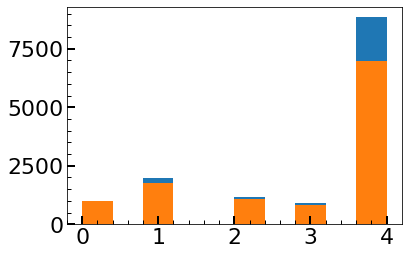

In [1345]:
#How many hit the smearing limit?
hist(scanData['liIt']);
hist(scanData['liIt'][scanData['cgood']]);
np.sum(scanData['liIt']<=3)

In [1423]:
#Find the full range of rates for each component for plotting
#v4: Updated getYfitCond version
def getERminmax_v4(scanData,cut,dosmear=True,seed=None,nAvg=1):
    R_er_test=[]
    R_nr_test=[]
    R_ng_test=[]
    
    for i in range(len(scanData['lE_nrs'][cut])):
        E_nrs=scanData['lE_nrs'][cut][i]
        Ys=scanData['lYs'][cut][i]
        fer=scanData['lfer'][cut][i]
        fnr=scanData['lfnr'][cut][i]
        fng=scanData['lfng'][cut][i]
        FanoER=scanData['lFanoER'][cut][i]
        FanoNR=scanData['lFanoNR'][cut][i]
        
        Y=getYfitCond_v4(E_nrs,Ys)
        
        
        R_er_avg=[]
        R_nr_avg=[]
        R_ng_avg=[]
        for iteration in range(nAvg):
            if dosmear:
                E_er_sm=spec.getSmeared(E_er,seed=seed,F=FanoER)
                E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed,F=FanoNR)
                E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed,F=FanoNR)
            else:
                E_er_sm=E_er
                E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
                E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)


            C_er,_=np.histogram(E_er_sm,bins=Ebins)
            R_er=fer*C_er/tlive_er

            C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
            R_nr=fnr*C_nr/tlive_nr

            C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
            R_ng=fng*C_ng/tlive_ng
            
            R_er_avg.append(R_er)
            R_nr_avg.append(R_nr)
            R_ng_avg.append(R_ng)

        R_er_test.append(np.mean(np.array(R_er_avg),axis=0))
        R_nr_test.append(np.mean(np.array(R_nr_avg),axis=0))
        R_ng_test.append(np.mean(np.array(R_ng_avg),axis=0))
    
    R_er_test=np.array(R_er_test)
    R_nr_test=np.array(R_nr_test)
    R_ng_test=np.array(R_ng_test)
    
    R_total_test=R_er_test+R_nr_test+R_ng_test

    Renvelopes={'eVee':Ebin_ctr,
                'ER':{'max':np.max(R_er_test,axis=0),'min':np.min(R_er_test,axis=0)},
                'NR':{'max':np.max(R_nr_test,axis=0),'min':np.min(R_nr_test,axis=0)},
                'NG':{'max':np.max(R_ng_test,axis=0),'min':np.min(R_ng_test,axis=0)},
                'Total':{'max':np.max(R_total_test,axis=0),'min':np.min(R_total_test,axis=0)},
               }
    return Renvelopes

#Find the full enevelope of yield curves
#Includes first and last point of each curve and the min and max Y at each Enr
def getEYenvelope_v4(lE_nrs_sample,lYs_sample,eVeeMin=50):
    Yenv_left=[]
    Yenv_right=[]
    Enr_env_left=[]
    Enr_env_right=[]

    for E_nrs,Ys in zip(lE_nrs_sample,lYs_sample):
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Yenv_left.append(Ys[cFit&(Ebin_ctr>eVeeMin)][0])
        Enr_env_left.append(E_nrs[cFit&(Ebin_ctr>eVeeMin)][0])
        Yenv_right.append(Ys[cFit&(Ebin_ctr>eVeeMin)][-1])
        Enr_env_right.append(E_nrs[cFit&(Ebin_ctr>eVeeMin)][-1])
        
    Enr_env_right=np.array(Enr_env_right)
    Yenv_right=np.array(Yenv_right)
    Enr_env_left=np.array(Enr_env_left)
    Yenv_left=np.array(Yenv_left)

    Enr_env_top=np.linspace(Enr_env_left[np.argmax(Yenv_left)],Enr_env_right[np.argmax(Yenv_right)],1000)
    Ytestmax=[]
    for E_nrs,Ys in zip(lE_nrs_sample,lYs_sample):
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Y=getYfitCond_v4(E_nrs,Ys)
        Ytesti=Y.calc(Enr_env_top)
        cgoodval=(Enr_env_top>=np.min(E_nrs[Ebin_ctr>eVeeMin]))
        Ytesti[~cgoodval]=-99
        Ytestmax.append(Ytesti)
    Yenv_top=np.max(np.array(Ytestmax),axis=0)        

    Enr_env_bottom=np.linspace(Enr_env_left[np.argmin(Yenv_left)],Enr_env_right[np.argmin(Yenv_right)],1000)
    Ytestmin=[]
    for E_nrs,Ys in zip(lE_nrs_sample,lYs_sample):
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Y=getYfitCond_v4(E_nrs,Ys)
        Ytesti=Y.calc(Enr_env_bottom)
        cgoodval=(Enr_env_bottom>=np.min(E_nrs[Ebin_ctr>eVeeMin]))
        Ytesti[~cgoodval]=99
        Ytestmin.append(Ytesti)
    Yenv_bottom=np.min(np.array(Ytestmin),axis=0)        

    #Need to sort the points so that they form a closed polygon
    #Go clockwise from top left

    Enr_env=np.concatenate( (Enr_env_top, Enr_env_right[np.argsort(Enr_env_right)], Enr_env_bottom[::-1], Enr_env_left[np.argsort(Enr_env_left)][::-1]) )
    Yenv=np.concatenate((Yenv_top, Yenv_right[np.argsort(Enr_env_right)], Yenv_bottom[::-1], Yenv_left[np.argsort(Enr_env_left)][::-1]))

    return (Enr_env, Yenv)

In [1432]:
#Collect the things we want to plot since it can take a while
EYenvelopes=[]
ERenvData=[]
ERmidData=[]
iBest=[]

mask=np.zeros(len(cut),dtype=bool)
mask[:]=True

#No NG
cut_noNG=(scanData['cgood'])&(scanData['lfng']==0)&(scanData['lFanoNR']==0.1161)&(scanData['liIt']<=3)
print(np.sum(cut_noNG&mask),np.sum(cut_noNG))
cut=cut_noNG&mask

iBest=np.argwhere(cut)[:,0][np.argmin(scanData['IzrChi'][cut])]#Best fit to Izr

EYenvelopes.append(getEYenvelope_v4(scanData['lE_nrs'][cut],scanData['lYs'][cut],eVeeMin=50))
ERenvData.append(getERminmax_v4(scanData,cut,nAvg=5))
#Cheat to get mid. min==max
ERmidData.append(getERminmax_v4(scanData,np.arange(len(scanData['lE_nrs']))==iBest,nAvg=5))

#With NG
cut_wNG=(scanData['cgood'])&(scanData['lfng']!=0)&(scanData['lFanoNR']==0.1161)&(scanData['liIt']<=3)
print(np.sum(cut_wNG&mask),np.sum(cut_wNG))
cut=cut_wNG&mask

iBest=np.argwhere(cut)[:,0][np.argmin(scanData['IzrChi'][cut])]#Best fit to Izr

EYenvelopes.append(getEYenvelope_v4(scanData['lE_nrs'][cut],scanData['lYs'][cut],eVeeMin=50))
ERenvData.append(getERminmax_v4(scanData,cut,nAvg=5))
#Cheat to get mid. min==max
ERmidData.append(getERminmax_v4(scanData,np.arange(len(scanData['lE_nrs']))==iBest,nAvg=5))

383 383
1474 1474


In [1435]:
iBest=[]

cut_noNG=(scanData['cgood'])&(scanData['lfng']==0)&(scanData['lFanoNR']==0.1161)&(scanData['liIt']<=3)
print(np.sum(cut_noNG&mask),np.sum(cut_noNG))
cut=cut_noNG&mask

iBest.append(np.argwhere(cut)[:,0][np.argmin(scanData['IzrChi'][cut])])

cut_wNG=(scanData['cgood'])&(scanData['lfng']!=0)&(scanData['lFanoNR']==0.1161)&(scanData['liIt']<=3)
print(np.sum(cut_wNG&mask),np.sum(cut_wNG))
cut=cut_wNG&mask

iBest.append(np.argwhere(cut)[:,0][np.argmin(scanData['IzrChi'][cut])])


383 383
1474 1474


In [1438]:
#Save results
import pickle

if False:
    with open( "data/intmeth_scan_v4_plotdata.p", "wb" ) as file:
        temp={'EYenvelopes':EYenvelopes,'ERenvData':ERenvData,'ERmidData':ERmidData, 'iBest':iBest}
        pickle.dump( temp, file )
else:
    with open( "data/intmeth_scan_v4_plotdata.p", "rb" ) as file:
        temp = pickle.load( file )
        EYenvelopes=temp['EYenvelopes']
        ERenvData=temp['ERenvData']
        ERmidData=temp['ERmidData']
        iBest=temp['iBest']

In [1587]:
iBest

[8960, 13128]

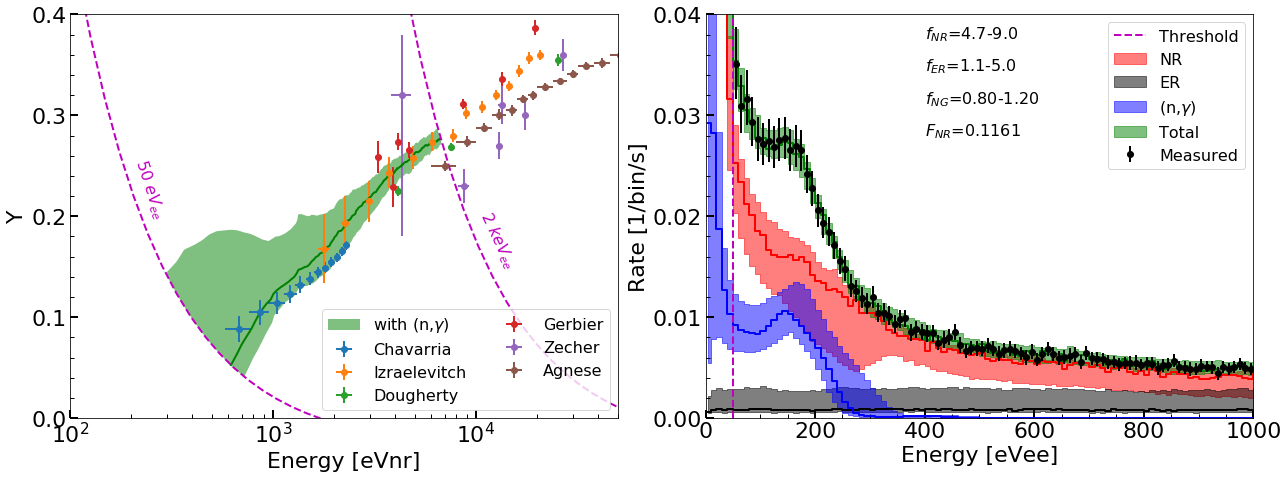

In [1597]:
fig_w=9
fig,axs=subplots(1,2,figsize=(2*fig_w, fig_w*(.75)))

iPlot=1

if iPlot==0:
    cut=cut_noNG
#    cut=(scanData['cgood'])&(scanData['lfng']==0)&(scanData['lFanoNR']==0.1161)&(scanData['liIt']<=3)
else:
    cut=cut_wNG
#    cut=(scanData['cgood'])&(scanData['lfng']!=0)&(scanData['lFanoNR']==0.1161)&(scanData['liIt']<=3)

#Best fit to Izr
#iBest=np.argwhere(cut)[:,0][np.argmin(scanData['IzrChi'][cut])]

labels=[r'no (n,$\gamma$)',r'with (n,$\gamma$)']
colors=['gray','green']


#Print some info
printValueRange(axs[1],4e2,4/5*0.047,r'$f_{NR}$=',scanData['lfnr'][cut],size=16)
printValueRange(axs[1],4e2,4/5*0.043,r'$f_{ER}$=',scanData['lfer'][cut],size=16)
printValueRange(axs[1],4e2,4/5*0.039,r'$f_{NG}$=',scanData['lfng'][cut]/2.04,size=16,fformat='.2f')
printValueRange(axs[1],4e2,4/5*0.035,r'$F_{NR}$=',scanData['lFanoNR'][cut],size=16,fformat='')


#Add other measurements from lit
import R68_plot_tools as pt
#pt.plotOldYs(axs[0],fmt='o',markersize=6)
pt.plotOldYs(axs[0],datasets=['chav','izr','dough','gerb','zech','agnese'],
             labels=['Chavarria','Izraelevitch','Dougherty','Gerbier','Zecher','Agnese'],
             fmt='o',markersize=6)

#axs[0].fill(*getEYenvelope(scanData['lE_nrs'][cut],scanData['lYs'][cut],eVeeMin=50),
#            colors[iPlot],alpha=0.5,label=labels[iPlot])
axs[0].fill(*EYenvelopes[iPlot],colors[iPlot],alpha=0.5,label=labels[iPlot])

axs[0].plot(scanData['lE_nrs'][iBest[iPlot]][Ebin_ctr>50],scanData['lYs'][iBest[iPlot]][Ebin_ctr>50], colors[iPlot])

axs[1].errorbar(Ebin_ctr[Ebin_ctr>50],R_meas[Ebin_ctr>50],(dR_meas.T[Ebin_ctr>50]).T,
                ecolor='k', marker='o',markersize=6,color='k', linestyle='none',label='Measured',zorder=5)

axs[0].set_prop_cycle(None)#Reset color cycle
axs[1].set_prop_cycle(None)


#ERenvData=getERminmax_v4(scanData,cut,nAvg=5)
#ERmidData=getERminmax_v4(scanData,np.arange(len(scanData['lE_nrs']))==iBest,nAvg=5)#Cheat to get mid. min==max

axs[1].step(ERmidData[iPlot]['eVee'],ERmidData[iPlot]['NR']['min'],color='r',where='mid')
axs[1].step(ERmidData[iPlot]['eVee'],ERmidData[iPlot]['ER']['min'],color='k',where='mid')
axs[1].step(ERmidData[iPlot]['eVee'],ERmidData[iPlot]['NG']['min'],color='b',where='mid')
axs[1].step(ERmidData[iPlot]['eVee'],ERmidData[iPlot]['Total']['min'],color='g',where='mid')

axs[1].fill_between(ERenvData[iPlot]['eVee'],ERenvData[iPlot]['NR']['min'],ERenvData[iPlot]['NR']['max'],color='r',alpha=0.5,step='mid',label='NR')
axs[1].fill_between(ERenvData[iPlot]['eVee'],ERenvData[iPlot]['ER']['min'],ERenvData[iPlot]['ER']['max'],color='k',alpha=0.5,step='mid',label='ER')
axs[1].fill_between(ERenvData[iPlot]['eVee'],ERenvData[iPlot]['NG']['min'],ERenvData[iPlot]['NG']['max'],color='b',alpha=0.5,step='mid',label=r'(n,$\gamma)$')
axs[1].fill_between(ERenvData[iPlot]['eVee'],ERenvData[iPlot]['Total']['min'],ERenvData[iPlot]['Total']['max'],color='g',alpha=0.5,step='mid',label='Total')


#Analysis Range
axs[1].axvline(50,linestyle='--',color='m',label='Threshold')

Yiso = lambda Enr,Eee: Eee/Enr*(1+eps/V)-eps/V
axs[0].plot(np.logspace(-2,5,100),Yiso(np.logspace(-2,5,100),50),'--m')
axs[0].plot(np.logspace(-2,5,100),Yiso(np.logspace(-2,5,100),2e3),'--m')

axs[0].text(2e2,0.2,r'50 $eV_{ee}$',size=16,color='m',rotation=-72)
axs[0].text(1e4,0.15,r'2 $keV_{ee}$',size=16,color='m',rotation=-65)

#Axes
#axs[0].set_xlim(0,5e2)
axs[0].set_xlim(1e2,5e4);
axs[0].set_xscale('log')
axs[0].set_ylim(0,0.4)
axs[0].yaxis.set_major_locator(plt.MultipleLocator(0.1))
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
axs[0].legend(loc='lower right',ncol=2,prop={'size': 16})

axs[1].set_ylim(0,0.04)
axs[1].yaxis.set_major_locator(plt.MultipleLocator(0.01))
axs[1].set_xlim(0,1e3)

#axs[1].set_ylim(0,0.05)
#axs[1].set_xlim(40,2e3)
#axs[1].set_xscale('log')

axs[1].set_xlabel('Energy [eVee]')
axs[1].set_ylabel('Rate [1/bin/s]')

axs[1].legend(loc='upper right', prop={'size': 16})

tight_layout()

if iPlot==0:
    savefig('figures/intmeth_izr_benchmark_noNG_FNRFER.png')
elif iPlot==1:
    savefig('figures/intmeth_izr_benchmark_wNG_FNRFER.png')

(100, 200)

In [1576]:
#Pick mins and maxes at 1 keV
#This isn't quite right, since envelope is not just from a single curve, but it's fine



ifng=np.argwhere(cut_wNG)
ifng_min=ifng[np.argmin(scanData['Y1keV'][ifng])][0]
ifng_max=ifng[np.argmax(scanData['Y1keV'][ifng])][0]

print(scanData['Y1keV'][ifng_max])

#Also just pick 100 randomly
ifng_rand=np.random.choice(ifng[:,0],100,replace=False)

[0.17815882]


In [1581]:
#Save the best fit yield points
if False:
    with open( "data/intmeth_scan_v4_bestYdata.p", "wb" ) as file:
        temp={'lE_nrs':scanData['lE_nrs'][iBest[1]], 'lYs':scanData['lYs'][iBest[1]],
             'lE_nrs_min':scanData['lE_nrs'][ifng_min], 'lYs_min':scanData['lYs'][ifng_min],
             'lE_nrs_max':scanData['lE_nrs'][ifng_max], 'lYs_max':scanData['lYs'][ifng_max],
             'lE_nrs_rand':scanData['lE_nrs'][ifng_rand], 'lYs_rand':scanData['lYs'][ifng_rand]}
        pickle.dump( temp, file )

In [1536]:
#NR equivalent threshold values for some yield models
#Also compare with arb threshold of 10 eVee

#Lindhard (k=0.146 for Si)
Y=Yield.Yield('Lind',[0.146])
print(f'Lind(k=0.146): {ERtoNR(50,Y,V,eps)[0]:.1f} eVnr')
print(f'Lind(k=0.146): {ERtoNR(10,Y,V,eps)[0]:.1f} eVnr')
print(f'Lind(k=0.146) 1e/h: {ERtoNR(1.14,Y,V,eps)[0]:.1f} eVnr')

#Integral Method
Y=getYfitCond_v4(scanData['lE_nrs'][iBest[1]],scanData['lYs'][iBest[1]])
print(f'IntMeth: {ERtoNR(50,Y,V,eps)[0]:.1f} eVnr')
print(f'IntMeth: {ERtoNR(10,Y,V,eps)[0]:.1f} eVnr')

#Sorensen MCMC best fit
Y=Yield.Yield('Sor',[0.178,0.003])
print(f'Sor(k=0.178,q=0.003): {ERtoNR(50,Y,V,eps)[0]:.1f} eVnr')
print(f'Sor(k=0.178,q=0.003): {ERtoNR(10,Y,V,eps)[0]:.1f} eVnr')


Lind(k=0.146): 252.8 eVnr
Lind(k=0.146): 59.5 eVnr
Lind(k=0.146) 1e/h: 8.4 eVnr
IntMeth: 621.1 eVnr
IntMeth: 338.9 eVnr
Sor(k=0.178,q=0.003): 667.2 eVnr
Sor(k=0.178,q=0.003): 338.9 eVnr


In [1528]:
#Should really put these calculations somewhere more useful
#Lindhard for Ge (Si) at 100(110) eV, that's the assumed SNOLAB iZIP threshold
Y=Yield.Yield('Lind',[0.157]) #Used <A>=72.8
print(f'Lind(k=0.157,100 eVee) (Ge): {ERtoNR(100,Y,V,eps)[0]:.1f} eVnr')
print(f'Lind(k=0.157,50 eVee) (Ge): {ERtoNR(50,Y,V,eps)[0]:.1f} eVnr')
print(f'Lind(k=0.157,3.0 eVee) (Ge): {ERtoNR(3.0,Y,V,eps)[0]:.1f} eVnr')
print(f'Lind(k=0.157,0.67 eVee) (Ge): {ERtoNR(0.67,Y,V,eps)[0]:.1f} eVnr')

Y=Yield.Yield('Lind',[0.146])
print(f'Lind(k=0.146,110 eVee) (Si): {ERtoNR(110,Y,V,eps)[0]:.1f} eVnr')
print(f'Lind(k=0.146,50 eVee) (Si): {ERtoNR(50,Y,V,eps)[0]:.1f} eVnr')
print(f'Lind(k=0.146,3.8 eVee) (Si): {ERtoNR(3.8,Y,V,eps)[0]:.1f} eVnr')
print(f'Lind(k=0.146,1.14 eVee) (Si): {ERtoNR(1.14,Y,V,eps)[0]:.1f} eVnr')

Lind(k=0.157,100 eVee) (Ge): 449.4 eVnr
Lind(k=0.157,50 eVee) (Ge): 241.5 eVnr
Lind(k=0.157,3.0 eVee) (Ge): 19.2 eVnr
Lind(k=0.157,0.67 eVee) (Ge): 5.0 eVnr
Lind(k=0.146,110 eVee) (Si): 512.0 eVnr
Lind(k=0.146,50 eVee) (Si): 252.8 eVnr
Lind(k=0.146,3.8 eVee) (Si): 24.9 eVnr
Lind(k=0.146,1.14 eVee) (Si): 8.4 eVnr


(0, 0.5)

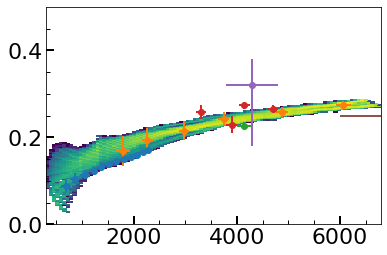

In [1611]:
#Plot yield curves as a heat map

cut=cut_wNG&mask

x=scanData['lE_nrs'][cut].ravel()
y=scanData['lYs'][cut].ravel()

from matplotlib.colors import LogNorm
hist2d(x[x>0],y[x>0],bins=(100,100),norm=LogNorm());

pt.plotOldYs(gca(),datasets=['chav','izr','dough','gerb','zech','agnese'],
             labels=['Chavarria','Izraelevitch','Dougherty','Gerbier','Zecher','Agnese'],
             fmt='o',markersize=6)

ylim(0,0.5)

In [1466]:
importlib.reload(pt)

<module 'R68_plot_tools' from '../python/R68_plot_tools.py'>